In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy import linalg as LA
from scipy.fft import fft,fftfreq
import scipy
import TwoIons as TI


In [ ]:
hbar = 1 *1e-34

def print_section():
    print("---------------------------------------------------------------------------------------------------------------------")
    return None
random.seed(42069) #Seed for reproducibility
T = 10 * 1e-3
kb = 1.38*1e-23
kappa = 0.248;
z0 = 3/4*2.7*1e-3;
r0 = 3/4*3.5*1e-3;
# a1 = -0.003;
# q1 = 0.25;#0.21801801801801804
omega_RF = 2*np.pi*5.2*1e6;
m1 = 135*1.66*(10**(-27))
m2 = 135*1.66*(10**(-27))
Q1 = 1*1.6*1e-19;
Q2 = 1*1.6*1e-19;
omega_r1 = omega_RF/2*np.sqrt(q1**2/2+a1)
V_DC = 18#-a1*m1*(3/4*2.7*1e-3)**2*omega_RF**2/(4*Q1*0.248)
V_RF = 1000#q1/(2*Q1)*(m1*r0**2*omega_RF**2)
c = 3*1e8
lambd = c/(607.426262*1e12)
alpha = 0.1 #0.5 for radial degeneracy
waist = 500*1e-6
epsilon0 = 8.85*1e-12

amu = 1.66*(10**(-27))

Gamma = 2*np.pi*15.2*1e6
detuning = -Gamma/2
k = 2*np.pi/lambd*np.array([1/2,1/2,1/np.sqrt(2)])
saturation = 0.1


rho = Q2/Q1
mu = m2/m1


omega_z1 = np.sqrt(2*Q1*kappa/(m1*z0**2)*V_DC)
omega_z2 = np.sqrt(2*Q2*kappa/(m2*z0**2)*V_DC)

omega_pond_1 = Q1*V_RF/(np.sqrt(2)*omega_RF*m1*r0**2)
omega_x1 = np.sqrt(omega_pond_1**2 - alpha*omega_z1**2)
omega_y1 = np.sqrt(omega_pond_1**2-(1-alpha)*omega_z1**2)

omega_pond2 = Q2*V_RF/(np.sqrt(2)*omega_RF*m2*r0**2)
omega_x2 = np.sqrt(omega_pond2**2-alpha*omega_z2**2)
omega_y2 = np.sqrt(omega_pond2**2-(1-alpha)*omega_z2**2)

zeq1 = (Q1*Q2/(4*np.pi*epsilon0*m1*omega_z1**2)*(1/(1+1/rho)**2))**(1/3)
zeq2 = -1/rho * zeq1
V_tickle = 0.5*V_DC
print_section()
print("DC Voltage: ",V_DC)
print("RF Voltage: ", V_RF )
print("Tickle Voltage: ", V_tickle)
print_section()
print("Equilibrium positions (µm): " , "z1 = ", zeq1 * 1e6, "    z2 = " ,zeq2 * 1e6)
def shapedCooler(t0,t1,t):
    if t0 < t <t1:
        width = t1-t0
        return (np.sin(np.pi/width*(t-t0)))**2
    else:
        return 0

def backgroundPainter(ax,nRepetitions,transferLength,coolerLength):                                         #Could write this more general, but will likely not be necessary.
    cycleLength = transferLength+coolerLength
    for j in range(nRepetitions):
        ax.axvspan(j*cycleLength,j*cycleLength+transferLength,facecolor = 'red',alpha = 0.3)
        ax.axvspan(j*cycleLength+transferLength,(j+1)*cycleLength,facecolor = 'blue',alpha = 0.3)
def verletCool(r1_init,r2_init,v1_init,v2_init,t_init,coolLength,init_state,system,voltages,dt,save_when,alpha):

    #r1_init = initial position of ion1 - np.array([x,y,z])
    #r2_init = initial position of ion2 - np.array([x,y,z])
    #v1_init = initial velocity of ion1 - np.array([x,y,z])
    #v2_init = initial velocity of ion2 - np.array([x,y,z])
    #t_init = initial time of verlet integration
    #coolLength  = duration of Cooling application
    #init_state = initial state of 
    #system = TI two_ion_system object for the trap/setup
    #voltages = DC and RF voltage -- [V_DC,V_RF]
    #save_when = how often to save data, code saves data every "save_when"'th point.
    #dt = time step for integration
    
    t = t_init
    t_end = t_init + coolLength
    pos1s = []
    vel1s = []
    pos2s = []
    vel2s = []
    ts = []
    states = []
    current_state = init_state
    current_pos1 = r1_init
    current_pos2 = r2_init

    current_vel1 = v1_init
    current_vel2 = v2_init

    counter = 0
    Q1 = system.q1
    Q2 = system.q2
    m1 = system.m1
    m2 = system.m2
    V_DC = voltages[0]
    V_RF = voltages[1]
    B12dts = []


    while t < t_end:
        next_t = t+dt                                                                                                                                   #Denote next time for later uses.
        Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)                                                                                           #Calculate coulomb force at time t
        current_force1 = TrapForce(Q1,current_pos1,V_DC,V_RF,alpha,t) + Fcoul                                  #Calculate total force on ion 1
        current_force2 = TrapForce(Q2,current_pos2,V_DC,V_RF,alpha,t) - Fcoul                                  #Calculate total force on ion 2
        s = saturation*shapedCooler(t_init,t_end,t)

        next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2                         #Calculate next position of ion 1, as per velocity verlet
        next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2                         #Calculate next position of ion 2, as per velocity verlet

        next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)                                                   #Calculate Coulomb force, at next time step

        next_force1 = TrapForce(Q1,next_pos1,V_DC,V_RF,alpha,next_t) + next_fcoul                              #Calculate forces on ion 1 and 2 at next timestep. Used for updating velocty
        next_force2 = TrapForce(Q2,next_pos2,V_DC,V_RF,alpha,next_t) - next_fcoul

        next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt                                 # Update new velocities
        next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt


        if current_state == 0:                                                                                 #This is the laser cooling logic tree. 0 = Ground state, 1 = Excited State.
            B12 = s*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel1))**2/(Gamma**2))                   #Calculate absorption rate
            rnd_nr = np.random.rand()
            if rnd_nr<B12*dt: #Absorb                                                                          #If TRUE: absorption happnes, velocity is updated and state changes
                next_vel1 +=hbar*k/m1
                current_state =1
        elif current_state ==1:                                                                                 
            B12 = s*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel1))**2/(Gamma**2))                   #If the ion was instead in the excited state, we once again check stim emission rate
            rnd_nr = np.random.rand()
            if rnd_nr < Gamma*dt:# spont emiss                                                                 #if TRUE spontaneous emission occurs, ion1 gets random kick
                next_vel1 += hbar/m1*k_norm*random_direction()
                current_state = 0
            elif rnd_nr < (Gamma+B12)*dt: #Stim emiss                                                          #else if TRUE stimulated emission occurs, ion1 gets a kick of -k
                next_vel1 -=hbar*k/m1
                current_state = 0

        if np.mod(counter,save_when) == 0:
            pos1s.append(current_pos1)                                                                         #Append positions and velocities, at every 500 time steps.
            pos2s.append(current_pos2)
            B12dts.append(s*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel1))**2/(Gamma**2)) * dt)
            vel1s.append(current_vel1)
            vel2s.append(current_vel2)
            states.append(current_state)
            ts.append(t)
            counter = 0
        t+=dt                                                                                                  #Increment time and the counter for data storage. Update positions and velocities.
        counter +=1
        current_pos1 = next_pos1
        current_vel1 = next_vel1
        current_pos2 = next_pos2
        current_vel2 = next_vel2
    return pos1s,pos2s,vel1s,vel2s,ts B12dts
def verletTransfer(r1_init,r2_init,v1_init,v2_init,omega1,omega2,t_init,duration,system,voltages,dt,save_when,alpha):
    V_DC = voltages[0]
    V_RF = voltages[1]
    VPrime = voltages[2]
    current_pos1 = r1_init
    current_vel1 = v1_init

    current_pos2 = r2_init
    current_vel2 = v2_init

    t = t_init
    counter = 0
    pos1s = []
    pos2s = []
    vel1s = []
    vel2s = []
    ts = []
    Q1 = system.q1
    Q2 = system.q2
    m1 = system.m1
    m2 = system.m2
    t_end = t_init+duration                                                                                               # THis number has been found empirically by trial and error
    while t < t_end:
        next_t = t+dt                                                                                                                                   #Denote next time for later uses.
        Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)                                                                                           #Calculate coulomb force at time t
        current_force1 = TrapForce(Q1,current_pos1,V_DC,V_RF,alpha,t) + Fcoul + TrapForce(Q1,current_pos1,shapedVTickle(t_init,duration,VPrime,t,omega1,omega2),0,0.5,t)                                 #Calculate total force on ion 1
        current_force2 = TrapForce(Q2,current_pos2,V_DC,V_RF,alpha,t) - Fcoul + TrapForce(Q2,current_pos2,shapedVTickle(t_init,duration,VPrime,t,omega1,omega2),0,0.5,t)                   #Calculate total force on ion 2


        next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2                         #Calculate next position of ion 1, as per velocity verlet
        next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2                         #Calculate next position of ion 2, as per velocity verlet

        next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)                                                   #Calculate Coulomb force, at next time step

        next_force1 = TrapForce(Q1,next_pos1,V_DC,V_RF,alpha,next_t) + next_fcoul + TrapForce(Q1,next_pos1,shapedVTickle(t_init,duration,VPrime,next_t,omega1,omega2),0,0.5,next_t)                              #Calculate forces on ion 1 and 2 at next timestep. Used for updating velocty
        next_force2 = TrapForce(Q2,next_pos2,V_DC,V_RF,alpha,next_t) - next_fcoul + TrapForce(Q2,next_pos2,shapedVTickle(t_init,duration,VPrime,next_t,omega1,omega2),0,0.5,next_t)

        next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt                                 # Update new velocities
        next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt

        if np.mod(counter,save_when) == 0:
            pos1s.append(current_pos1)                                                                         #Append positions and velocities, at every 500 time steps.
            pos2s.append(current_pos2)

            vel1s.append(current_vel1)
            vel2s.append(current_vel2)
            #print(Fcoul,current_force1-Fcoul)
            ts.append(t)
            counter = 0
        t+=dt                                                                                                  #Increment time and the counter for data storage. Update positions and velocities.
        counter +=1
        current_pos1 = next_pos1
        current_vel1 = next_vel1
        current_pos2 = next_pos2
        current_vel2 = next_vel2
    return pos1s,pos2s,vel1s,vel2s,ts
def coolAndTransfer(r1_init,r2_init,v1_init,v2_init,omega1,omega2,t_init,duration,system,voltages,dt,save_when,alpha,s,k_vector):
    V_DC = voltages[0]
    V_RF = voltages[1]
    VPrime = voltages[2]
    current_pos1 = r1_init
    current_vel1 = v1_init
    current_state = 0
    current_pos2 = r2_init
    current_vel2 = v2_init

    t = t_init
    counter = 0
    pos1s = []
    pos2s = []
    vel1s = []
    vel2s = []
    ts = []
    Q1 = system.q1
    Q2 = system.q2
    m1 = system.m1
    m2 = system.m2
    t_end = t_init+duration   
    k_norm = LA.norm(k_vector)                                                                                            # THis number has been found empirically by trial and error
    while t < t_end:
        next_t = t+dt                                                                                                                                   #Denote next time for later uses.
        Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)                                                                                           #Calculate coulomb force at time t
        current_force1 = TrapForce(Q1,current_pos1,V_DC,V_RF,alpha,t) + Fcoul + TrapForce(Q1,current_pos1,VTickle(VPrime,t,omega1,omega2),0,0.5,t)                                 #Calculate total force on ion 1
        current_force2 = TrapForce(Q2,current_pos2,V_DC,V_RF,alpha,t) - Fcoul + TrapForce(Q2,current_pos2,VTickle(VPrime,t,omega1,omega2),0,0.5,t)                   #Calculate total force on ion 2


        next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2                         #Calculate next position of ion 1, as per velocity verlet
        next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2                         #Calculate next position of ion 2, as per velocity verlet

        next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)                                                   #Calculate Coulomb force, at next time step

        next_force1 = TrapForce(Q1,next_pos1,V_DC,V_RF,alpha,next_t) + next_fcoul + TrapForce(Q1,next_pos1,VTickle(VPrime,next_t,omega1,omega2),0,0.5,next_t)                              #Calculate forces on ion 1 and 2 at next timestep. Used for updating velocty
        next_force2 = TrapForce(Q2,next_pos2,V_DC,V_RF,alpha,next_t) - next_fcoul + TrapForce(Q2,next_pos2,VTickle(VPrime,next_t,omega1,omega2),0,0.5,next_t)

        next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt                                 # Update new velocities
        next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt


        if current_state == 0:                                                                                 #This is the laser cooling logic tree. 0 = Ground state, 1 = Excited State.
            B12 = s*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel1))**2/(Gamma**2))                   #Calculate absorption rate
            rnd_nr = np.random.rand()
            if rnd_nr<B12*dt: #Absorb                                                                          #If TRUE: absorption happnes, velocity is updated and state changes
                next_vel1 +=hbar*k/m1
                current_state =1
        elif current_state ==1:                                                                                 
            B12 = s*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel1))**2/(Gamma**2))                   #If the ion was instead in the excited state, we once again check stim emission rate
            rnd_nr = np.random.rand()
            if rnd_nr < Gamma*dt:# spont emiss                                                                 #if TRUE spontaneous emission occurs, ion1 gets random kick
                next_vel1 += hbar/m1*k_norm*random_direction()
                current_state = 0
            elif rnd_nr < (Gamma+B12)*dt: #Stim emiss                                                          #else if TRUE stimulated emission occurs, ion1 gets a kick of -k
                next_vel1 -=hbar*k/m1
                current_state = 0
        
        if np.mod(counter,save_when) == 0:
            pos1s.append(current_pos1)                                                                         #Append positions and velocities, at every 500 time steps.
            pos2s.append(current_pos2)

            vel1s.append(current_vel1)
            vel2s.append(current_vel2)
            #print(Fcoul,current_force1-Fcoul)
            ts.append(t)
            counter = 0
        t+=dt                                                                                                  #Increment time and the counter for data storage. Update positions and velocities.
        counter +=1
        current_pos1 = next_pos1
        current_vel1 = next_vel1
        current_pos2 = next_pos2
        current_vel2 = next_vel2
    return pos1s,pos2s,vel1s,vel2s,ts

def shapedVTickle(t_start,duration,V,t,omega1,omega2):
    tprime = t-t_start
    if (tprime < 0.2*duration) & (tprime > 0):
        return tprime/(0.2*duration)*V*np.sin((omega1-omega2)*tprime)
    elif (tprime > 0.2*duration) & (tprime < 0.8*duration):
        return V*np.sin((omega1-omega2)*tprime)
    elif (duration>tprime >0.8*duration):
        return V*np.sin((omega1-omega2)*tprime) * (tprime-duration)/(-0.2*(duration))
    else:
        return 0
def meanCalculator(numberOfPoints,array):
    result = []
    for j in range(int(np.floor(len(array)/numberOfPoints))):
        result.append(1/numberOfPoints*np.sum(array[j*numberOfPoints:(j+1)*numberOfPoints]))
    return np.array(result)

def TrapForce(q,r,V_DC,V_RF,alpha,t):
    #r is 3d vector (x,y,z)
    z = r[2]
    x = r[0]
    y = r[1]
    Fz = -q*2*kappa*V_DC/(z0**2) * z
    Fy = q*(2*(1-alpha)*kappa*V_DC/(z0**2) *y -V_RF/(r0**2)*y*np.cos(omega_RF*t))
    Fx = q*(2*alpha*kappa*V_DC/(z0**2) *x +V_RF/(r0**2)*x*np.cos(omega_RF*t))
    return  np.array([Fx,Fy,Fz])
# def TrapForcePseudo(q,r,V_DC,V_RF,alpha,t):
#     z = r[2]
#     x = r [0]
#     y = r[1]

#     aParamM = -(4*q*kappa*V_DC)/(z0**2*omega_RF**2)


def displacementWProjection(r1,r2,req1,req2,m1,m2,vec):
    amu = 1.66*(10**(-27))
    return np.sqrt(m1/amu)*vec[0]*(r1-req1)+np.sqrt(m2/amu)*vec[1]*(r2-req2)


def random_direction():
    u,v = np.random.rand(2)
    phi = 2*np.pi*u                                                                                         #phi angle (physics convention) in spherical coordinates i.e. phi is i nrange [0,2pi]
    theta = np.arccos(1-2*v)                                                                                #theta nagle (physics convention) in spherical coordinates. i.e. theta is in range [0,pi]
    return np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])

def modeKineticEnergy(mode_vector, weightedVelocity1,weightedVelocity2):
    return 0.5*(mode_vector[0]**2 * weightedVelocity1**2 + mode_vector[1]**2 *weightedVelocity2**2)                 #Calculate kinetic energy in the mode "mode vector", 
                                                                                                                    #given two sqrt(m) weighted velocities

def VTickle(V,t,omega1,omega2):
    return V*np.sin((omega1-omega2)*t)
def CoulombForce(q1,q2,r1,r2):
    return q1*q2/(4*np.pi*epsilon0)*(r1-r2)/LA.norm(r1-r2)**3



---------------------------------------------------------------------------------------------------------------------
DC Voltage:  18
RF Voltage:  1000
Tickle Voltage:  9.0
---------------------------------------------------------------------------------------------------------------------
Equilibrium positions (µm):  z1 =  5.486990943447822     z2 =  -5.486990943447822


In [ ]:
deltaZ = zeq1-zeq2
K11 = omega_z1**2 + Q1*Q2/(4*np.pi*epsilon0*m1) * (2/deltaZ**3)
K12 = -Q1*Q2/(4*np.pi*epsilon0*np.sqrt(m1*m2)) * (2/deltaZ**3)
K22 = omega_z2**2 + Q1*Q2/(4*np.pi*epsilon0*m2) * (2/deltaZ**3)

K33 = omega_x1**2 - Q1*Q2/(4*np.pi*epsilon0*m1) * (1/deltaZ**3)
K34 = -0.5*K12
K44 = omega_x2**2 - Q1*Q2/(4*np.pi*epsilon0*m2) * (1/deltaZ**3)

K55 = omega_y1**2 - Q1*Q2/(4*np.pi*epsilon0*m1) * (1/deltaZ**3)
K56 = K34
K66 = omega_y2**2 - Q1*Q2/(4*np.pi*epsilon0*m2) * (1/deltaZ**3)

KZ = np.array([[K11,K12],[K12,K22]])
KX = np.array([[K33,K34],[K34,K44]])
KY = np.array([[K55,K56],[K56,K66]])




z_freqs2, z_vecs = LA.eig(KZ)
y_freqs2, y_vecs = LA.eig(KY)
x_freqs2, x_vecs = LA.eig(KX)

print(x_freqs2,x_vecs)
print(y_freqs2,y_vecs)
print(z_freqs2,z_vecs)



z_freqs = np.sqrt(z_freqs2)
y_freqs = np.sqrt(y_freqs2)
x_freqs = np.sqrt(x_freqs2)



print_section()
print("z frequencies are (kHz) : ", (z_freqs[0])/(2*np.pi*1e3),"     ", (z_freqs[1])/(2*np.pi*1e3))
print("z eigenvectors are: ", z_vecs[:,0], "        ", z_vecs[:,1])
print_section()
print("x frequencies are (kHz) : ", (x_freqs[0])/(2*np.pi*1e3),"     ", (x_freqs[1])/(2*np.pi*1e3))
print("x eigenvectors are: ", x_vecs[:,0], "        ", x_vecs[:,1])
print_section()
print("y frequencies are (kHz) : ", (y_freqs[0])/(2*np.pi*1e3),"     ", (y_freqs[1])/(2*np.pi*1e3))
print("y eigenvectors are: ", y_vecs[:,0], "        ", y_vecs[:,1])
print_section()
if np.sign(z_vecs[0,0]) == np.sign(z_vecs[1,0]):
    z_in_mode = z_vecs[:,0]
    freqZin = z_freqs[0]
    z_out_mode = z_vecs[:,1]
    freqZout = z_freqs[1]
else:
    z_in_mode = z_vecs[:,1]
    freqZin = z_freqs[1]
    freqZout = z_freqs[0]
    z_out_mode = z_vecs[:,0]

if np.sign(x_vecs[0,0]) == np.sign(x_vecs[1,0]):
    x_in_mode = x_vecs[:,0]
    x_out_mode = x_vecs[:,1]
else:
    x_in_mode = x_vecs[:,1]
    x_out_mode = x_vecs[:,0]

if np.sign(y_vecs[0,0]) == np.sign(y_vecs[1,0]):
    y_in_mode = y_vecs[:,0]
    y_out_mode = y_vecs[:,1]
else:
    y_in_mode = y_vecs[:,1]
    y_out_mode = y_vecs[:,0]

print(omega_pond_1)
#Remember to include z-tickle in radial direction as well.

[4.87310105e+12 3.31863138e+12] [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[3.62952532e+12 2.07505565e+12] [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[4.66340901e+12 1.55446967e+12] [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
---------------------------------------------------------------------------------------------------------------------
z frequencies are (kHz) :  343.6939483642933       198.43179360697025
z eigenvectors are:  [ 0.70710678 -0.70710678]          [0.70710678 0.70710678]
---------------------------------------------------------------------------------------------------------------------
x frequencies are (kHz) :  351.33615190192376       289.93432863179976
x eigenvectors are:  [0.70710678 0.70710678]          [-0.70710678  0.70710678]
---------------------------------------------------------------------------------------------------------------------
y frequencies are (kHz) :  303.2110655335459       229.26354605106567
y eigenvectors

Above is all just the settings for the run. We now write some Verlet integration for the 2-ion problem

In [60]:
x1_init = 1e-5*x_in_mode[0]/np.sqrt(m1/amu)+1e-5*x_out_mode[0]/np.sqrt(m1/amu)
x2_init = 1e-5*x_in_mode[1]/np.sqrt(m2/amu)+1e-5*x_out_mode[1]/np.sqrt(m2/amu)


y1_init = 1e-5*y_in_mode[0]/np.sqrt(m1/amu)+1e-5*y_out_mode[0]/np.sqrt(m1/amu)
y2_init = 1e-5*y_in_mode[1]/np.sqrt(m2/amu)+1e-5*y_out_mode[1]/np.sqrt(m2/amu)

z1_init = zeq1+1e-5*z_in_mode[0]/np.sqrt(m1/amu)+1e-5*z_out_mode[0]/(np.sqrt(m1/amu))
z2_init = zeq2+1e-5*z_in_mode[1]/np.sqrt(m2/amu)+1e-5*z_out_mode[1]/(np.sqrt(m2/amu))

r1_init = np.array([x1_init,y1_init,z1_init])
r2_init = np.array([x2_init,y2_init,z2_init])

v1_init = np.zeros(3)
v2_init = np.zeros(3)

t_init = 0
t_end = 1*1e-4

dt = 1e-10
t = 0
ts = []
positions = []
velocities = []
print("Initial Time: ", t_init)
print("End Time: ", t_end)
print("Time Step: ", dt)
print("Total number of steps: ",int(np.floor(t_end/dt)))
print_section()
print("Initial position 1 (µm): ", r1_init*1e6)
print("Initial velcoity 1 (m/s): ", v1_init)

print("Initial position 2 (µm): ", r2_init*1e6)
print("Initial velcoity 2 (m/s): ", v2_init)

print_section()
print("Secular z-direction Barium Frequency (kHz):  ", omega_z1/(2*np.pi*1e3))
print("Secular x-direction Barium Frequency (kHz):  ", omega_x1/(2*np.pi*1e3))
print("Secular y-direction Barium Frequency (kHz):  ", omega_y1/(2*np.pi*1e3))
print_section()
print_section()
print("z frequencies are (kHz) : ", (z_freqs[0])/(2*np.pi*1e3),"     ", (z_freqs[1])/(2*np.pi*1e3))
print("z eigenvectors are: ", z_vecs[:,0], "        ", z_vecs[:,1])
print_section()
print("x frequencies are (kHz) : ", (x_freqs[0])/(2*np.pi*1e3),"     ", (x_freqs[1])/(1*np.pi*1e3))
print("x eigenvectors are: ", x_vecs[:,0], "        ", x_vecs[:,1])
print_section()
print("y frequencies are (kHz) : ", (y_freqs[0])/(2*np.pi*1e3),"     ", (y_freqs[1])/(1*np.pi*1e3))
print("y eigenvectors are: ", y_vecs[:,0], "        ", y_vecs[:,1])
print_section()
print('Equilibrium displacements for ion 1 are (µm): ',(np.array([0,0,zeq1])-r1_init)*1e6)
print('Equilibrium displacements for ion 2 are (µm): ',(np.array([0,0,zeq2])-r2_init)*1e6)

print_section()

print(Q1,Q2)


Initial Time:  0
End Time:  0.0001
Time Step:  1e-10
Total number of steps:  1000000
---------------------------------------------------------------------------------------------------------------------
Initial position 1 (µm):  [0.         0.         6.70415218]
Initial velcoity 1 (m/s):  [0. 0. 0.]
Initial position 2 (µm):  [ 1.21716124  1.21716124 -5.48699094]
Initial velcoity 2 (m/s):  [0. 0. 0.]
---------------------------------------------------------------------------------------------------------------------
Secular z-direction Barium Frequency (kHz):   198.43179360697025
Secular x-direction Barium Frequency (kHz):   351.33615190192376
Secular y-direction Barium Frequency (kHz):   303.2110655335459
---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
z frequencies are (kHz) :  343.6939483642933    

In [61]:
current_pos1 = r1_init
current_vel1 = v1_init

current_pos2 = r2_init
current_vel2 = v2_init




counter = 0
pos1s = []
pos2s = []
vel1s = []
vel2s = []
ts = []

while t < t_end:
    next_t = t+dt
    Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)
    current_force1 = TrapForce(Q1,current_pos1,V_DC,V_RF,alpha,t) + Fcoul
    current_force2 = TrapForce(Q2,current_pos2,V_DC,V_RF,alpha,t) - Fcoul


    next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2
    next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2

    next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)

    next_force1 = TrapForce(Q1,next_pos1,V_DC,V_RF,alpha,next_t) + next_fcoul
    next_force2 = TrapForce(Q2,next_pos2,V_DC,V_RF,alpha,next_t) - next_fcoul

    next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt
    next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt




    if np.mod(counter,500) == 0:
        pos1s.append(current_pos1)
        pos2s.append(current_pos2)

        vel1s.append(current_vel1)
        vel2s.append(current_vel2)
        #print(Fcoul,current_force1-Fcoul)
        ts.append(t)
    t+=dt
    current_pos1 = next_pos1
    current_vel1 = next_vel1
    current_pos2 = next_pos2
    current_vel2 = next_vel2


Text(0.5, 0, 'Time (ms)')

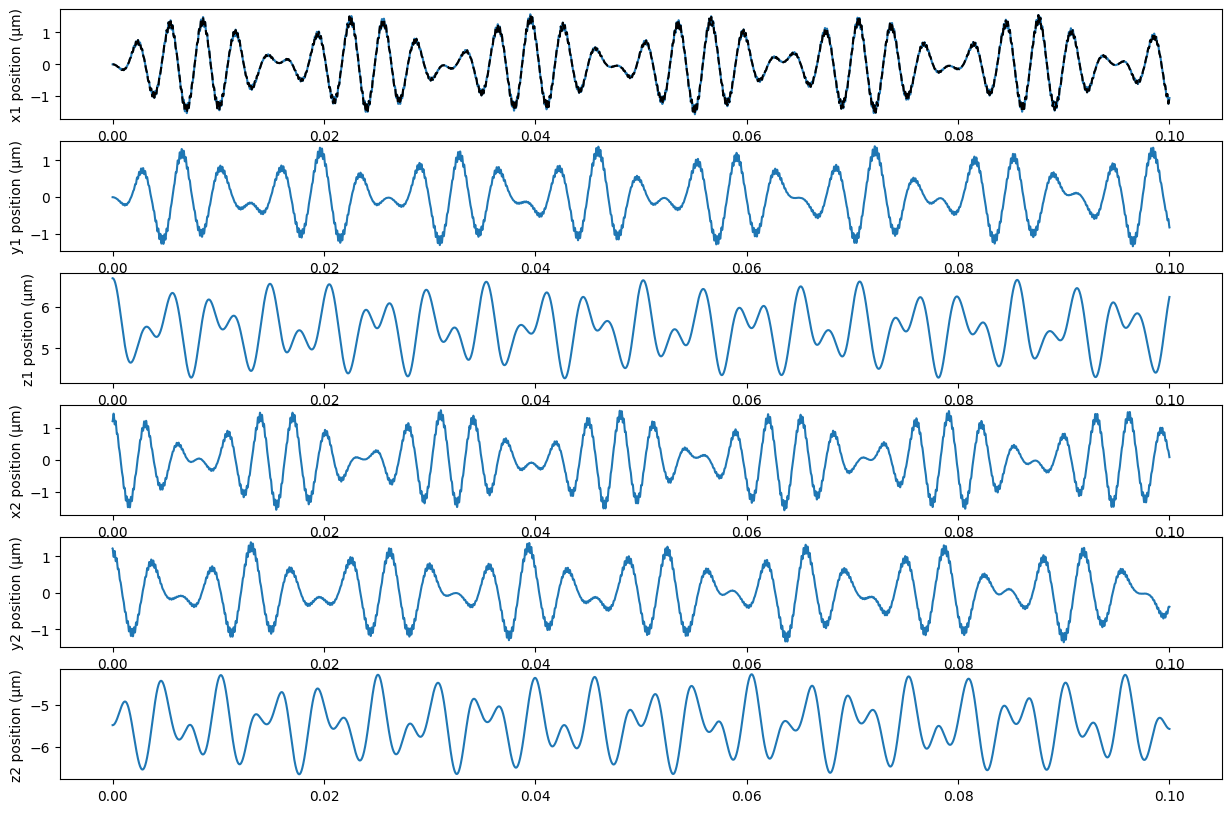

In [65]:
fig,ax = plt.subplots(6,1,figsize = (15,10))
z1s = []
y1s = []
x1s = []


x2s = []
y2s = []
z2s = []
for position in pos1s:
    z1s.append(position[2])
    y1s.append(position[1])
    x1s.append(position[0])

for position in pos2s:
    z2s.append(position[2])
    y2s.append(position[1])
    x2s.append(position[0])
x1s = np.array(x1s)
x2s = np.array(x2s)
y1s = np.array(y1s)
y2s = np.array(y2s)
z1s = np.array(z1s)
z2s = np.array(z2s)
extraXS = np.loadtxt(r'C:\Users\au581149\PhD-Work\Two-Ion-Systems\Clean 2 Ion Code\NewSimXs.txt')
extraTs = np.loadtxt(r'C:\Users\au581149\PhD-Work\Two-Ion-Systems\Clean 2 Ion Code\NewSimTs.txt')
ax[0].plot(np.array(extraTs)*1e3,extraXS*1e6, ls = '--', color = 'k',zorder = 500)
ax[0].plot(np.array(ts)*1e3,x1s*1e6)
ax[1].plot(np.array(ts)*1e3,y1s*1e6)
ax[2].plot(np.array(ts)*1e3,z1s*1e6)



ax[3].plot(np.array(ts)*1e3,x2s*1e6)
ax[4].plot(np.array(ts)*1e3,y2s*1e6)
ax[5].plot(np.array(ts)*1e3,z2s*1e6)

ax[0].set_ylabel('x1 position (µm)')
ax[1].set_ylabel('y1 position (µm)')
ax[2].set_ylabel('z1 position (µm)')
ax[3].set_ylabel('x2 position (µm)')
ax[4].set_ylabel('y2 position (µm)')
ax[5].set_ylabel('z2 position (µm)')



ax[2].set_xlabel('Time (ms)')

Now that we have some arbitrary movement. Let's see if we can break it into the two eigenmodes of the motion! We start by looking at mass-weighted equilibrium displacement instead of full position.

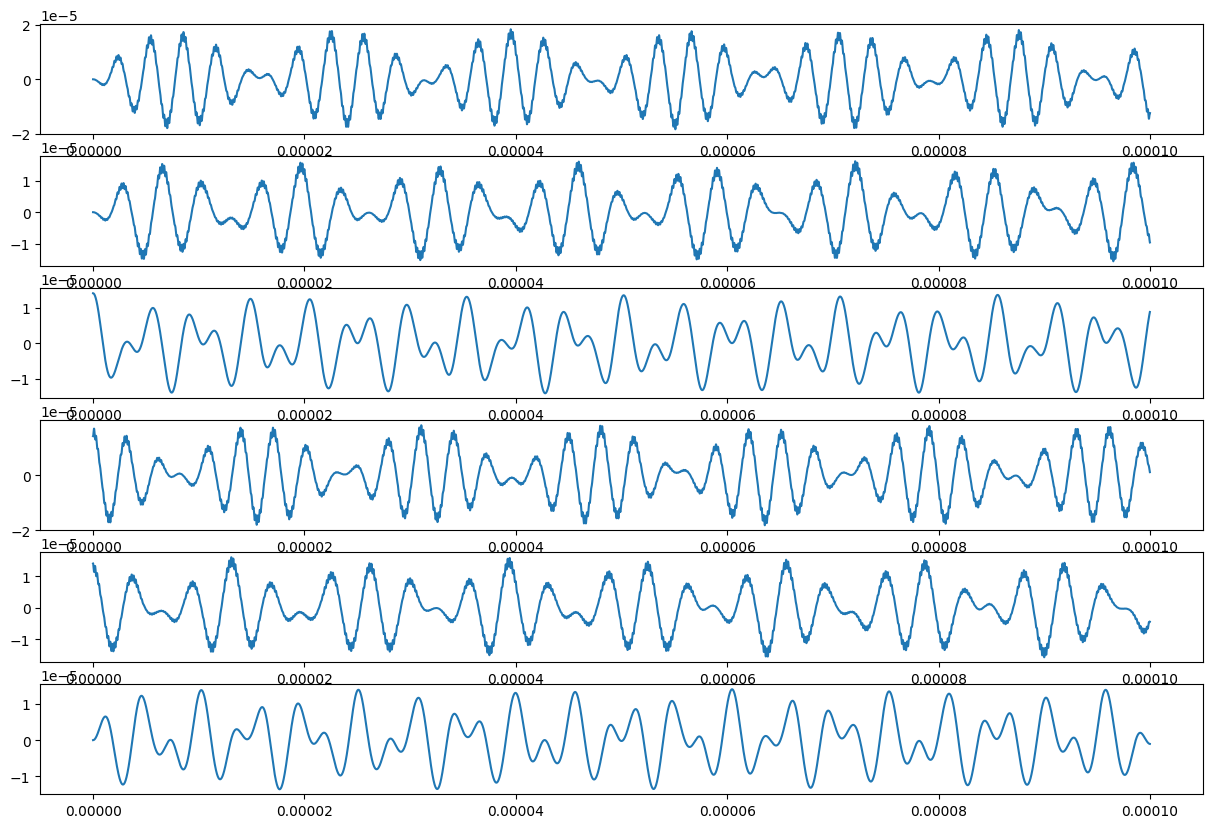

In [66]:
weighted_displacements1 = []
weighted_displacements2 = []

weighted_displacements_x1 = []
weighted_displacements_y1 = []
weighted_displacements_z1 = []

weighted_displacements_x2 = []
weighted_displacements_y2 = []
weighted_displacements_z2 = []

for position1 ,position2 in zip(pos1s,pos2s):
    weighted_displace_z1 = (position1[2]-zeq1)*np.sqrt(m1/amu)
    weighted_displace_y1 = position1[1]*np.sqrt(m1/amu)
    weighted_displace_x1 = position1[0]*np.sqrt(m1/amu)

    weighted_displacements_x1.append(weighted_displace_x1)
    weighted_displacements_y1.append(weighted_displace_y1)
    weighted_displacements_z1.append(weighted_displace_z1)
    weighted_displacements1.append(np.array([weighted_displace_x1,weighted_displace_y1,weighted_displace_z1]))
    
    weighted_displace_x2 = (position2[0])*np.sqrt(m2/amu)
    weighted_displace_y2 = position2[1]*np.sqrt(m2/amu)
    weighted_displace_z2 = (position2[2]-zeq2)*np.sqrt(m2/amu)

    weighted_displacements_x2.append(weighted_displace_x2)
    weighted_displacements_y2.append(weighted_displace_y2)
    weighted_displacements_z2.append(weighted_displace_z2)
    weighted_displacements2.append(np.array([weighted_displace_x2,weighted_displace_y2,weighted_displace_z2]))

fig,ax = plt.subplots(6,1,figsize = (15,10))
ax[0].plot(ts,weighted_displacements_x1)
ax[1].plot(ts,weighted_displacements_y1)
ax[2].plot(ts,weighted_displacements_z1)
ax[3].plot(ts,weighted_displacements_x2)
ax[4].plot(ts,weighted_displacements_y2)
ax[5].plot(ts,weighted_displacements_z2)

With the mass-weighted coordinates in place. We are ready to look at projections!

Text(0, 0.5, 'x - in phase\nprojection')

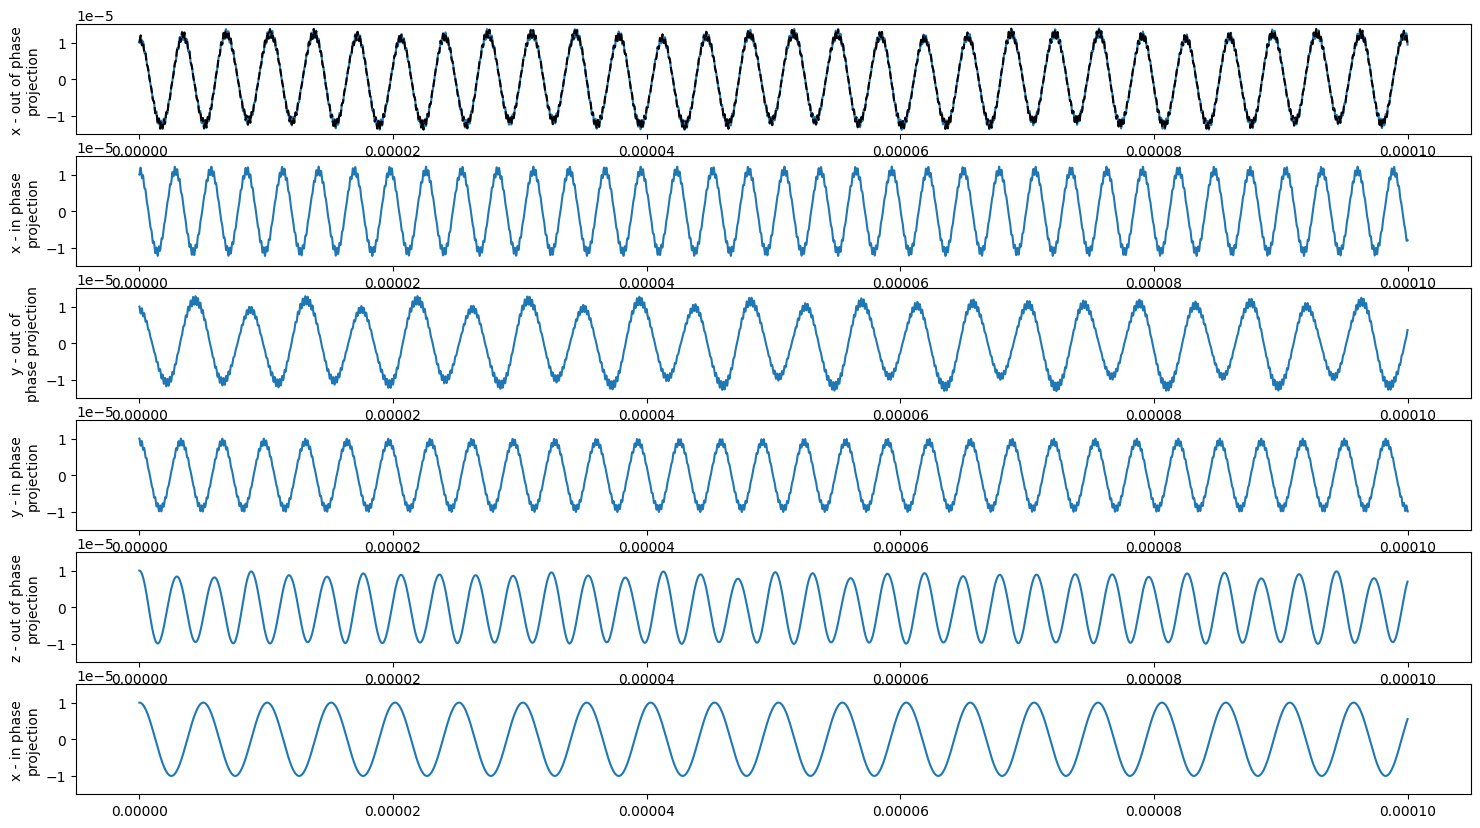

In [68]:
dot_z_out = [np.dot(np.array([z1,z2]),z_out_mode) for z1,z2 in zip(weighted_displacements_z1,weighted_displacements_z2)]
dot_z_in = [np.dot(np.array([z1,z2]),z_in_mode) for z1,z2 in zip(weighted_displacements_z1,weighted_displacements_z2)]

dot_x_in = [np.dot(np.array([x1,x2]),x_in_mode) for x1,x2 in zip(weighted_displacements_x1,weighted_displacements_x2)]
dot_x_out = [np.dot(np.array([x1,x2]),x_out_mode) for x1,x2 in zip(weighted_displacements_x1,weighted_displacements_x2)]

dot_y_in = [np.dot(np.array([y1,y2]),y_in_mode) for y1,y2 in zip(weighted_displacements_y1,weighted_displacements_y2)]
dot_y_out = [np.dot(np.array([y1,y2]),y_out_mode) for y1,y2 in zip(weighted_displacements_y1,weighted_displacements_y2)]


fig,ax = plt.subplots(6,1,figsize = (18,10))
ax[0].plot(ts,dot_x_out)
ax[1].plot(ts,dot_x_in)
ax[2].plot(ts,dot_y_out)
ax[3].plot(ts,dot_y_in)
ax[4].plot(ts,dot_z_out)
ax[5].plot(ts,dot_z_in)

for j in range(6):
    ax[j].set_ylim(1.5*(-1e-5),1.5*1e-5)


extraXOut = np.loadtxt(r'C:\Users\au581149\PhD-Work\Two-Ion-Systems\Clean 2 Ion Code\NewSimXOut.txt')
ax[0].plot(extraTs,extraXOut, ls = '--', color = 'k', zorder  =500)
ax[0].set_ylabel('x - out of phase\nprojection')
ax[1].set_ylabel('x - in phase\nprojection')
ax[2].set_ylabel('y - out of\nphase projection')
ax[3].set_ylabel('y - in phase\nprojection')
ax[4].set_ylabel('z - out of phase\nprojection')
ax[5].set_ylabel('x - in phase\nprojection')

Very nice! We are clearly able to disassemble the motion into these eigenstates. What's even nicer is that we are clearly able to see micromotion even in the projections when these go away from their equilibria!

In [ ]:
k_norm = LA.norm(k)

current_pos1 = r1_init
current_vel1 = v1_init

current_pos2 = r2_init
current_vel2 = v2_init



t = 0
counter = 0
pos1s = []
pos2s = []
vel1s = []
vel2s = []
ts = []
current_state = 0
B12dts = []
t_end = 1*1e-4

while t < t_end:
    next_t = t+dt                                                                                          #Denote next time for later uses.
    Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)                                                  #Calculate coulomb force at time t
    current_force1 = TrapForce(Q1,current_pos1,V_DC,V_RF,alpha,t) + Fcoul                                  #Calculate total force on ion 1
    current_force2 = TrapForce(Q2,current_pos2,V_DC,V_RF,alpha,t) - Fcoul                                  #Calculate total force on ion 2


    next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2                         #Calculate next position of ion 1, as per velocity verlet
    next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2                         #Calculate next position of ion 2, as per velocity verlet

    next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)                                                   #Calculate Coulomb force, at next time step

    next_force1 = TrapForce(Q1,next_pos1,V_DC,V_RF,alpha,next_t) + next_fcoul                              #Calculate forces on ion 1 and 2 at next timestep. Used for updating velocty
    next_force2 = TrapForce(Q2,next_pos2,V_DC,V_RF,alpha,next_t) - next_fcoul

    next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt                                 # Update new velocities
    next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt


    if current_state == 0:                                                                                 #This is the laser cooling logic tree. 0 = Ground state, 1 = Excited State.
        B12 = saturation*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel1))**2/(Gamma**2))                   #Calculate absorption rate
        rnd_nr = np.random.rand()
        if rnd_nr<B12*dt: #Absorb                                                                          #If TRUE: absorption happnes, velocity is updated and state changes
            next_vel1 +=hbar*k/m1
            current_state =1
    elif current_state ==1:                                                                                 
        B12 = saturation*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel1))**2/(Gamma**2))                   #If the ion was instead in the excited state, we once again check stim emission rate
        rnd_nr = np.random.rand()
        if rnd_nr < Gamma*dt:# spont emiss                                                                 #if TRUE spontaneous emission occurs, ion1 gets random kick
            next_vel1 += hbar/m1*k_norm*random_direction()
            current_state = 0
        elif rnd_nr < (Gamma+B12)*dt: #Stim emiss                                                          #else if TRUE stimulated emission occurs, ion1 gets a kick of -k
            next_vel1 -=hbar*k/m1
            current_state = 0


    if np.mod(counter,1000) == 0:
        pos1s.append(current_pos1)                                                                         #Append positions and velocities, at every 500 time steps.
        pos2s.append(current_pos2)
        B12dts.append(B12*dt)
        vel1s.append(current_vel1)
        vel2s.append(current_vel2)
        #print(Fcoul,current_force1-Fcoul)
        ts.append(t)
        counter = 0
    t+=dt                                                                                                 #Increment time and the counter for data storage. Update positions and velocities.
    counter +=1
    current_pos1 = next_pos1
    current_vel1 = next_vel1
    current_pos2 = next_pos2
    current_vel2 = next_vel2


KeyboardInterrupt: 

In [ ]:
#Save the data from the simulation into txt files so we don't have to redo simulation al the time.


# np.savetxt('position1_10ms.txt',np.array(pos1s))
# np.savetxt('position2_10ms.txt',np.array(pos2s))
# np.savetxt('velocity1_10ms.txt',np.array(vel1s))
# np.savetxt('velocity2_10ms.txt',np.array(vel2s))
# np.savetxt('times_10ms.txt',np.array(ts))


# pos1s = np.loadtxt('position1_10ms.txt')
# pos2s = np.loadtxt('position2_10ms.txt')
# vel1s = np.loadtxt('velocity1_10ms.txt')
# vel2s = np.loadtxt('velocity2_10ms.txt')
# ts = np.loadtxt('times_10ms.txt')

Let's transform the results into weighted displacements and look at the motion!

In [ ]:
weightedCoolDisplacements1 = []
weightedCoolDisplacements2 = []

print(type(pos1s[0]))

for position1,position2 in zip(pos1s,pos2s):
    weightedCoolDisplacements1.append(position1-[0,0,zeq1])                                         #Just appending elements to the list. Not actually weighted yet
    weightedCoolDisplacements2.append(position2-[0,0,zeq2])                                         #Just appending elements to the list. Not actually weighted yet

weightedCoolDisplacements1 = np.array(weightedCoolDisplacements1)*np.sqrt(m1/amu)         #Actually weighting the elements now, and turning into np arraty
weightedCoolDisplacements2 = np.array(weightedCoolDisplacements2)*np.sqrt(m2/amu)         # ------ II -------


cooledZOut = []                                                                           # Initialize lists for the projections of motion.
cooledZIn = []
cooledXOut = []
cooledXIn = []
cooledYOut = []
cooledYIn = []

for weightDisp1,weightDisp2 in zip(weightedCoolDisplacements1,weightedCoolDisplacements2):# Loop over positions to calculate the dotproducts!
    cooledXOut.append(np.dot(np.array([weightDisp1[0],weightDisp2[0]]),x_out_mode))
    cooledXIn.append(np.dot(np.array([weightDisp1[0],weightDisp2[0]]),x_in_mode))
    cooledYOut.append(np.dot(np.array([weightDisp1[1],weightDisp2[1]]),y_out_mode))
    cooledYIn.append(np.dot(np.array([weightDisp1[1],weightDisp2[1]]),y_in_mode))
    cooledZOut.append(np.dot(np.array([weightDisp1[2],weightDisp2[2]]),z_out_mode))
    cooledZIn.append(np.dot(np.array([weightDisp1[2],weightDisp2[2]]),z_in_mode))
print(weightedCoolDisplacements1.shape)
print('no. of data points is: ',len(ts))

<class 'numpy.ndarray'>
(93600, 3)
no. of data points is:  93600


Text(0, 0.5, 'z - in phase\nprojection')

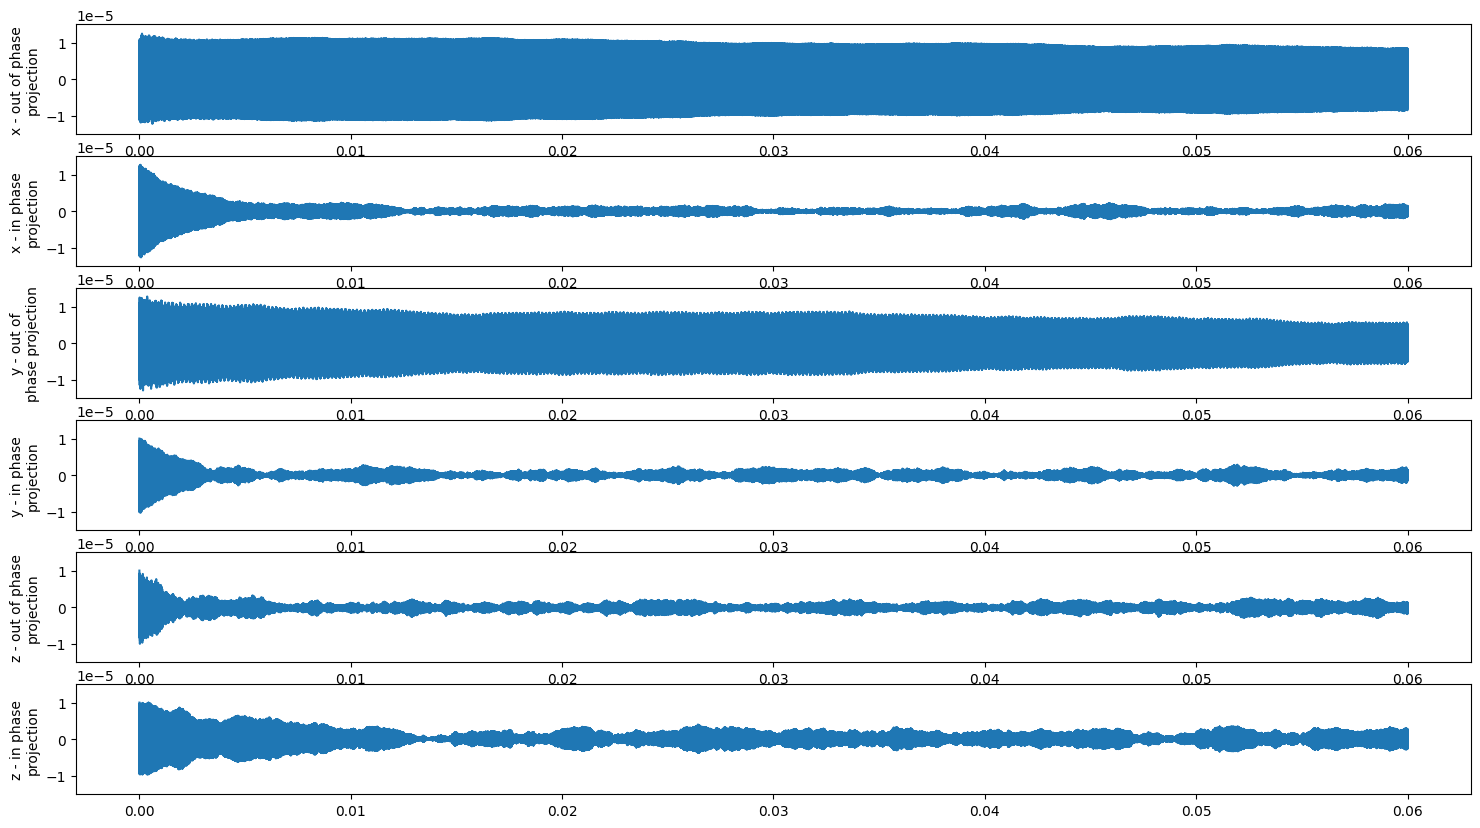

In [ ]:
fig,ax = plt.subplots(6,1,figsize = (18,10))

# ax[0].plot(ts,dot_x_out)
# ax[1].plot(ts,dot_x_in)
# ax[2].plot(ts,dot_y_out)
# ax[3].plot(ts,dot_y_in)
# ax[4].plot(ts,dot_z_out)
# ax[5].plot(ts,dot_z_in)

ax[0].plot(ts,cooledXOut)
ax[1].plot(ts,cooledXIn)
ax[2].plot(ts,cooledYOut)
ax[3].plot(ts,cooledYIn)
ax[4].plot(ts,cooledZOut)
ax[5].plot(ts,cooledZIn)

for j in range(6):
    ax[j].set_ylim(1.5*(-1e-5),1.5*1e-5)

ax[0].set_ylabel('x - out of phase\nprojection')
ax[1].set_ylabel('x - in phase\nprojection')
ax[2].set_ylabel('y - out of\nphase projection')
ax[3].set_ylabel('y - in phase\nprojection')
ax[4].set_ylabel('z - out of phase\nprojection')
ax[5].set_ylabel('z - in phase\nprojection')

Let's determine the temperatures (kinetic energy) of each mode! Assume the two modes of some direction $\eta$ are denoted by $\eta_{in},\eta_{out}$ then the kinetic energy associated with a given mode will be:

$K_\nu = 1/2(\frac{d}{dt}\eta_\nu)^2,\quad \eta_\nu = \alpha_{\nu,1}\delta r_1+\alpha_{\nu,2} \delta r_2$ where the coordinates are weighted.

In [ ]:
weightedCoolVelocities1 = []
weightedCoolVelocities2 = []

for vel1,vel2 in zip(vel1s,vel2s):
    weightedCoolVelocities1.append(np.sqrt(m1)*vel1)
    weightedCoolVelocities2.append(np.sqrt(m2)*vel2)

KZIn = []
KZOut = []
KXIn = []
KXOut = []
KYIn = []
KYOut = []
K1 = []
K2 = []



for wVel1,wVel2 in zip(weightedCoolVelocities1,weightedCoolVelocities2):
    vX1 = wVel1[0] 
    vX2 = wVel2[0]
    vY1 = wVel1[1]
    vY2 = wVel2[1]
    vZ1 = wVel1[2]
    vZ2 = wVel2[2]
    K1.append(0.5*wVel1**2)
    K2.append(0.5*wVel2**2)
    KZIn.append(modeKineticEnergy(z_in_mode,vZ1,vZ2))
    KZOut.append(modeKineticEnergy(z_out_mode,vZ1,vZ2))
    KYIn.append(modeKineticEnergy(y_in_mode,vY1,vY2))
    KYOut.append(modeKineticEnergy(y_out_mode,vY1,vY2))
    KXIn.append(modeKineticEnergy(x_in_mode,vX1,vX2))
    KXOut.append(modeKineticEnergy(x_out_mode,vX1,vX2))
KZIn = np.array(KZIn)
KZOut = np.array(KZOut)
KXIn = np.array(KXIn)
KXOut = np.array(KXOut)
KYIn = np.array(KYIn)
KYOut = np.array(KYOut)

Let's do some plots of the energy contributions now! Of course, as always we multiply by 2/kB to get the result in mK (each degree of freedom gets  1/2 kb*T)

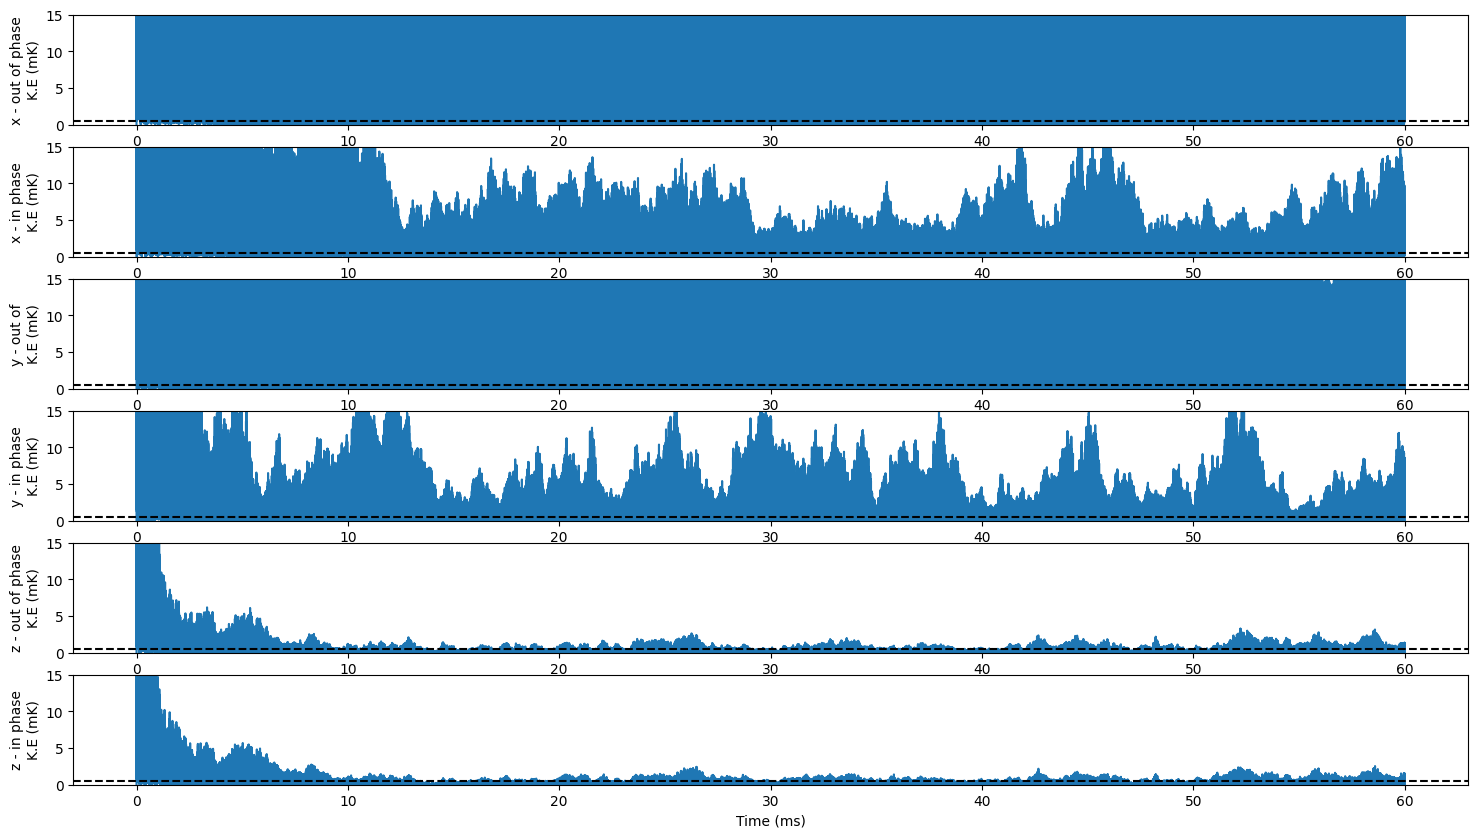

In [ ]:
fig,ax = plt.subplots(6,1,figsize = (18,10))
ts = np.array(ts)

ax[0].plot(ts*1e3,2*KXOut/kb*1e3)
ax[1].plot(ts*1e3,2*KXIn/kb*1e3)
ax[2].plot(ts*1e3,2*KYOut/kb*1e3)
ax[3].plot(ts*1e3,2*KYIn/kb*1e3)
ax[4].plot(ts*1e3,2*KZOut/kb*1e3)
ax[5].plot(ts*1e3,2*KZIn/kb*1e3)


ax[0].set_ylabel('x - out of phase\nK.E (mK)')
ax[1].set_ylabel('x - in phase\nK.E (mK)')
ax[2].set_ylabel('y - out of\nK.E (mK)')
ax[3].set_ylabel('y - in phase\nK.E (mK)')
ax[4].set_ylabel('z - out of phase\nK.E (mK)')
ax[5].set_ylabel('z - in phase\nK.E (mK)')
ax[5].set_xlabel('Time (ms)')

for axe in ax:
    axe.set_ylim(0,15)
    axe.axhline(0.5,color = 'k', ls = '--')

Let's do a sum check just to make sure our calculations are right. Since we have the velocities of the ions we can also calculate their individual K.E's The sum of the modes K.E. should be equal to the sum of the two ions'

(93600, 3)


Text(0.5, 0, 'Time (ms)')

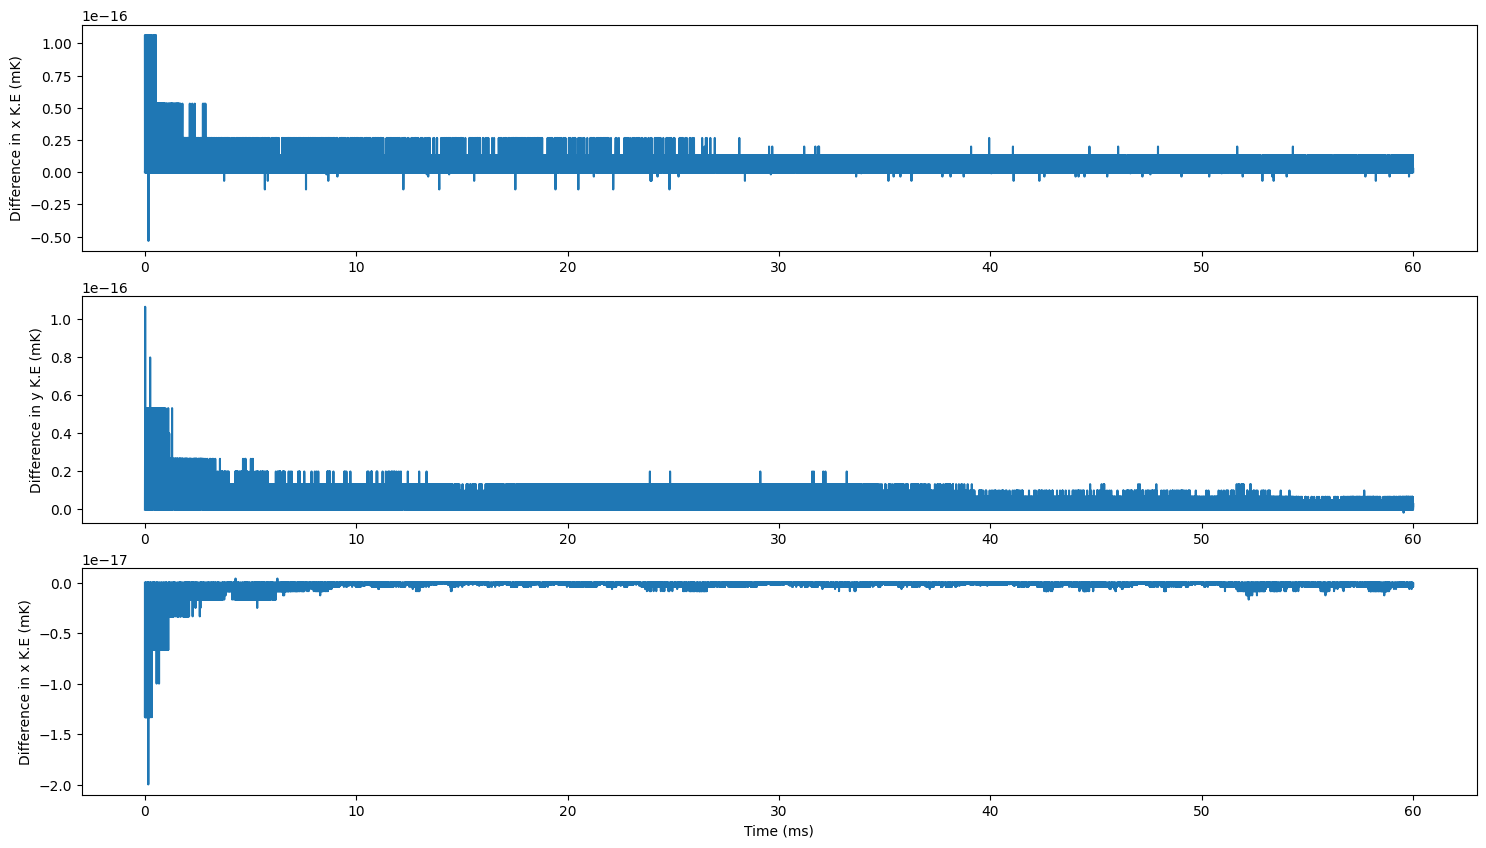

In [ ]:
fig,ax = plt.subplots(3,1,figsize = (18,10))
print(np.array(K1).shape)
ax[0].plot(ts*1e3,((np.array(K1)[:,0]+np.array(K2)[:,0])-(KXOut+KXIn))/(kb/2))
ax[1].plot(ts*1e3,2/kb * ((np.array(K1)[:,1]+np.array(K2)[:,1])-(KYOut+KYIn)))
ax[2].plot(ts*1e3,2/kb * ((np.array(K1)[:,2]+np.array(K2)[:,2])-(KZOut+KZIn)))

ax[0].set_ylabel('Difference in x K.E (mK)')
ax[1].set_ylabel('Difference in y K.E (mK)')
ax[2].set_ylabel('Difference in x K.E (mK)')
ax[2].set_xlabel('Time (ms)')

Let's get a better measure of the temperature by averaging over 50 consecutive points

In [ ]:
tdiff = np.diff(ts)[0]
intervalNumber = 50
intervalWidth = intervalNumber*tdiff
print('Averaging over ', intervalWidth*1e3, 'ms')
qrt = 0





KZInMean = meanCalculator(intervalNumber,KZIn)
KZOutMean = meanCalculator(intervalNumber,KZOut)
KXInMean = meanCalculator(intervalNumber,KXIn)
KXOutMean = meanCalculator(intervalNumber,KXOut)
KYInMean = meanCalculator(intervalNumber,KYIn)
KYOutMean = meanCalculator(intervalNumber,KYOut)
tMean = meanCalculator(intervalNumber,ts)


Averaging over  0.03205128205128191 ms


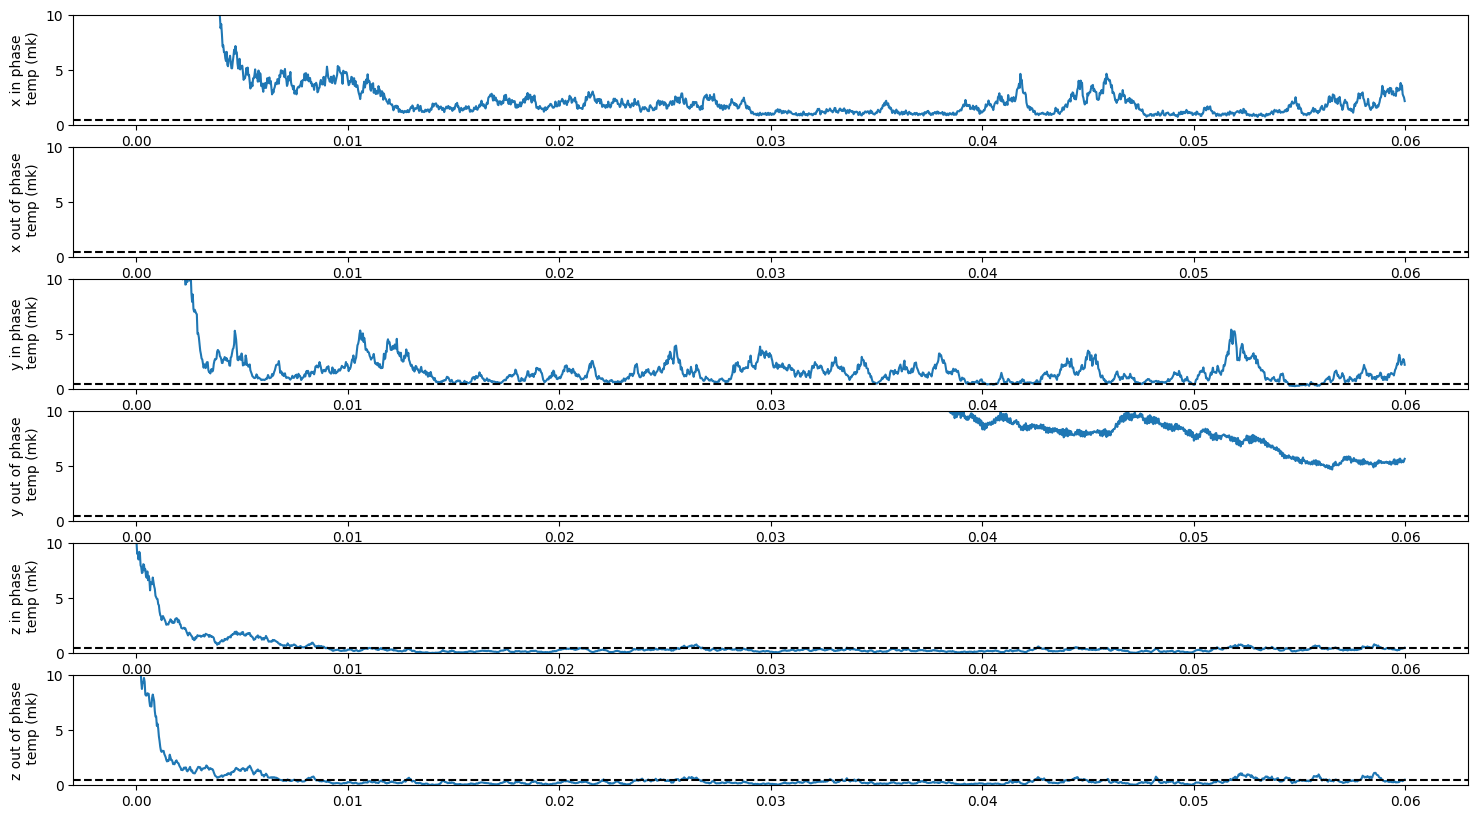

In [ ]:
fig,ax = plt.subplots(6,1,figsize = (18,10))
energies = [KXInMean,KXOutMean,KYInMean,KYOutMean,KZInMean,KZOutMean]
ylabels = ['x in phase\n temp (mk)','x out of phase\n temp (mk)','y in phase\n temp (mk)','y out of phase\n temp (mk)', 'z in phase\n temp (mk)','z out of phase\n temp (mk)']

for axe,kMean,ylabel in zip(ax,energies,ylabels):
    axe.plot(tMean,1e3*np.array(kMean)/kb*2)
    axe.set_ylabel(ylabel)
    axe.set_ylim(0,10)
    axe.axhline(0.5,color = 'k', ls = '--')


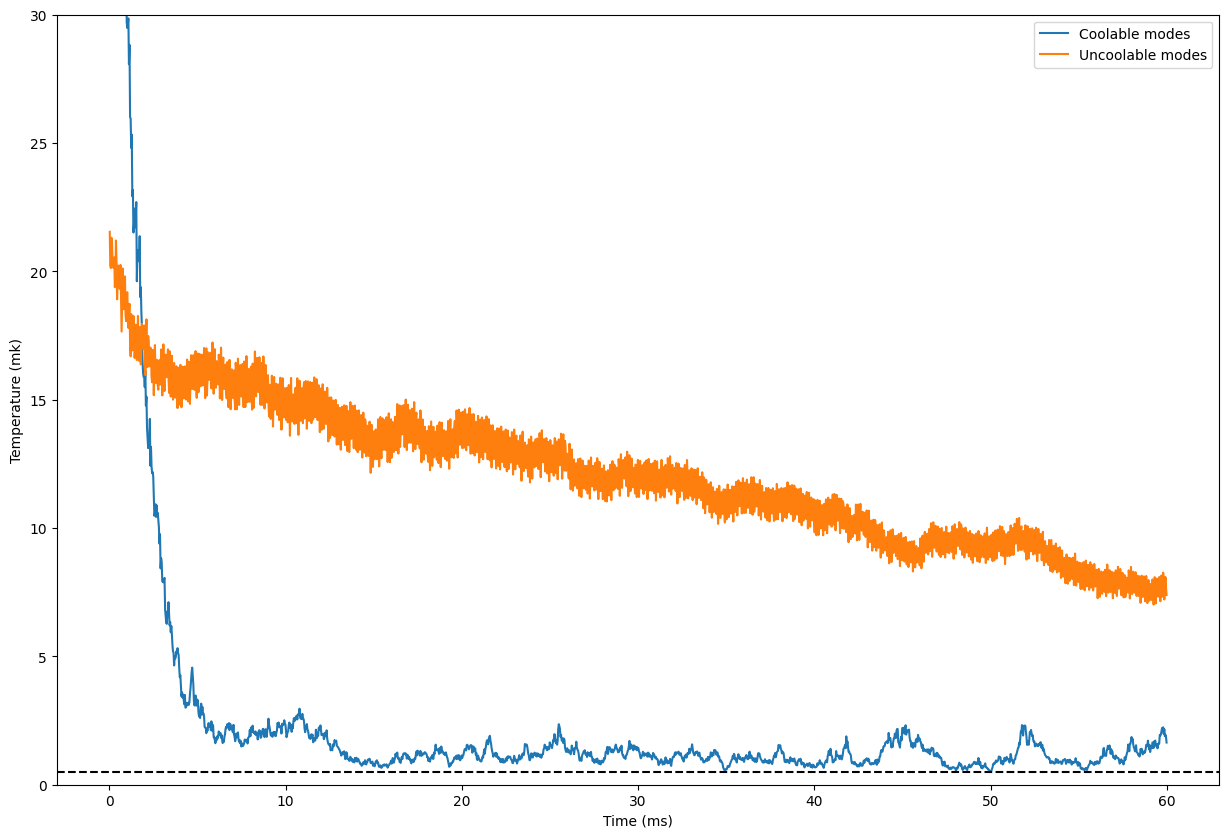

In [ ]:
fig,ax = plt.subplots(figsize = (15,10))

ax.plot(np.array(tMean)*1e3,1e3*2/3/kb*(np.array(KZOutMean)+np.array(KYInMean)+np.array(KXInMean)),label = 'Coolable modes')
ax.axhline(0.5,color = 'k', ls ='--')
ax.plot(np.array(tMean)*1e3,1e3*2/3/kb*(np.array(KZInMean)+np.array(KXOutMean)+np.array(KYOutMean)),label = 'Uncoolable modes')
ax.set_ylabel('Temperature (mk)')
ax.set_xlabel('Time (ms)')
ax.legend()
ax.set_ylim(0,30)
plt.savefig('WCM_SCM_Temp.png')



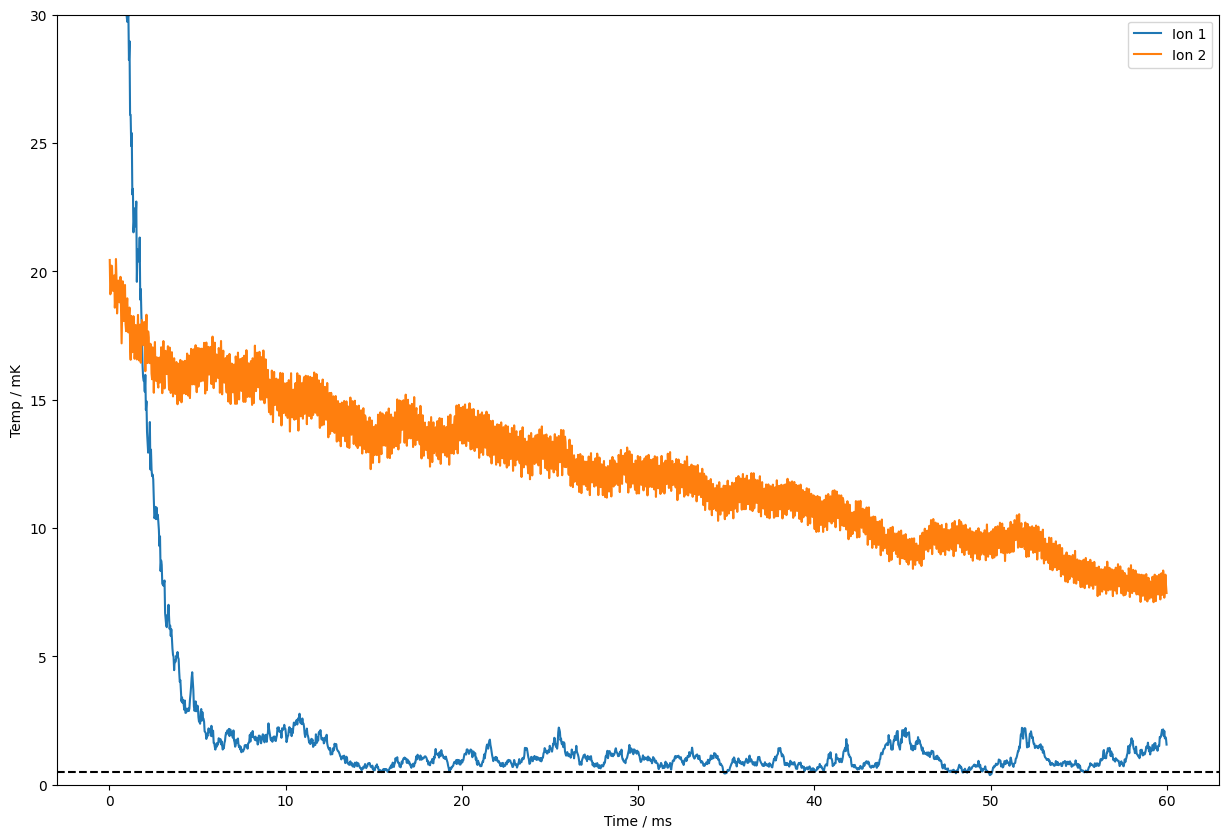

In [ ]:
fig,ax = plt.subplots(figsize = (15,10))

vX1s = np.array(vel1s)[:,0]
vY1s = np.array(vel1s)[:,1]
vZ1s = np.array(vel1s)[:,2]

vX2s = np.array(vel2s)[:,0]
vY2s = np.array(vel2s)[:,1]
vZ2s = np.array(vel2s)[:,2]


KX1Mean = meanCalculator(intervalNumber,0.5*m1*vX1s**2)
KX2Mean = meanCalculator(intervalNumber,0.5*m2*vX2s**2)

KY1Mean = meanCalculator(intervalNumber,0.5*m1*vY1s**2)
KY2Mean = meanCalculator(intervalNumber,0.5*m2*vY2s**2)

KZ1Mean = meanCalculator(intervalNumber,0.5*m1*vZ1s**2)
KZ2Mean = meanCalculator(intervalNumber,0.5*m2*vZ2s**2)

ax.plot(tMean*1e3,1e3*2/3/kb*(KX1Mean+KY1Mean+KZ1Mean),label = 'Ion 1')
ax.plot(tMean*1e3,1e3*2/3/kb*(KX2Mean+KY2Mean+KZ2Mean),label = 'Ion 2')

ax.axhline(0.5,ls = '--',color = 'k')
ax.legend()
ax.set_ylim(0,30)
ax.set_xlabel('Time / ms')
ax.set_ylabel('Temp / mK')
plt.savefig('Ion1Ion2Temp.png')

Clearly cooling works, but there isn't really much in the way of sympathetic cooling, since the motional modes are effectively uncoupled. But what if we deliberately try to couple the modes?
This is done by adding a tickle (in the z direction for now), which varies with the difference of the two mode frequencies.

In [ ]:
VPrime = 0*V_DC#1/5*V_DC





current_pos1 = r1_init
current_vel1 = v1_init

current_pos2 = r2_init
current_vel2 = v2_init







t = 0
counter = 0
pos1s = []
pos2s = []
vel1s = []
vel2s = []
ts = []
current_state = 0

t_end = 1*1e-4

while t < t_end:
    next_t = t+dt                                                                                                                                   #Denote next time for later uses.
    Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)                                                                                           #Calculate coulomb force at time t
    current_force1 = TrapForce(Q1,current_pos1,V_DC+VTickle(VPrime,t,z_freqs[0],z_freqs[1]),V_RF,alpha,t) + Fcoul                                  #Calculate total force on ion 1
    current_force2 = TrapForce(Q2,current_pos2,V_DC+VTickle(VPrime,t,z_freqs[0],z_freqs[1]),V_RF,alpha,t) - Fcoul                                  #Calculate total force on ion 2


    next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2                         #Calculate next position of ion 1, as per velocity verlet
    next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2                         #Calculate next position of ion 2, as per velocity verlet

    next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)                                                   #Calculate Coulomb force, at next time step

    next_force1 = TrapForce(Q1,next_pos1,V_DC+VTickle(VPrime,next_t,z_freqs[0],z_freqs[1]),V_RF,alpha,next_t) + next_fcoul                              #Calculate forces on ion 1 and 2 at next timestep. Used for updating velocty
    next_force2 = TrapForce(Q2,next_pos2,V_DC+VTickle(VPrime,next_t,z_freqs[0],z_freqs[1]),V_RF,alpha,next_t) - next_fcoul

    next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt                                 # Update new velocities
    next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt

    if np.mod(counter,100) == 0:
        pos1s.append(current_pos1)                                                                         #Append positions and velocities, at every 500 time steps.
        pos2s.append(current_pos2)

        vel1s.append(current_vel1)
        vel2s.append(current_vel2)
        #print(Fcoul,current_force1-Fcoul)
        ts.append(t)
        counter = 0
    t+=dt                                                                                                  #Increment time and the counter for data storage. Update positions and velocities.
    counter +=1
    current_pos1 = next_pos1
    current_vel1 = next_vel1
    current_pos2 = next_pos2
    current_vel2 = next_vel2





1560


Text(0.5, 0, 'Time ms')

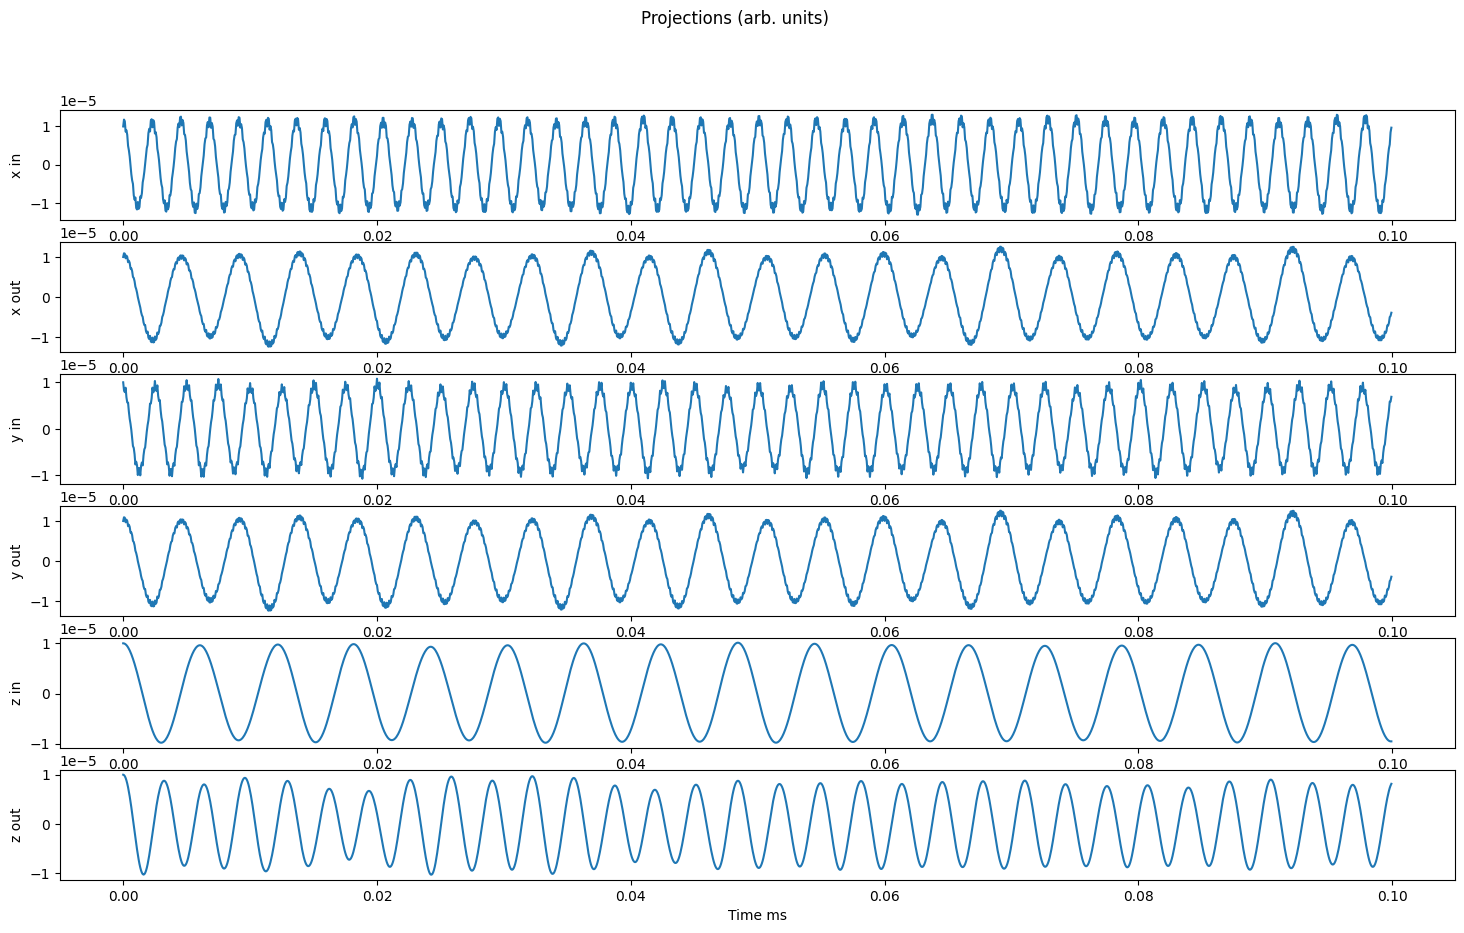

In [ ]:
np.savetxt('Clean2ion_r1.txt',pos1s)
np.savetxt('Clean2ion_r2.txt',pos2s)
np.savetxt('Clean2ion_v1.txt',vel1s)
np.savetxt('Clean2ion_v2.txt',vel2s)
np.savetxt('Clean2ion_t.txt',ts)





fig,ax = plt.subplots(6,1,figsize =(18,10))
vel1s = np.array(vel1s)
vel2s = np.array(vel2s)
pos1s = np.array(pos1s)
pos2s = np.array(pos2s)


projZin = []
projZout = []
projXin = []
projXout = []
projYin = []
projYout = []





for x1,x2,y1,y2,z1,z2 in zip(pos1s[:,0],pos2s[:,0],pos1s[:,1],pos2s[:,1],pos1s[:,2],pos2s[:,2]):
    projZin.append(displacementWProjection(z1,z2,zeq1,zeq2,m1,m2,z_in_mode))
    projZout.append(displacementWProjection(z1,z2,zeq1,zeq2,m1,m2,z_out_mode))
    projXin.append(displacementWProjection(x1,x2,0,0,m1,m2,x_in_mode))
    projXout.append(displacementWProjection(x1,x2,0,0,m1,m2,x_out_mode))
    projYin.append(displacementWProjection(y1,y2,0,0,m1,m2,y_in_mode))
    projYout.append(displacementWProjection(y1,y2,0,0,m1,m2,y_out_mode))



yLabels = ['x in', 'x out','y in','y out','z in','z out']
cleanProjections = [projXin,projXout,projYin,projXout,projZin,projZout]
for ys,axe,label in zip(cleanProjections,ax,yLabels):
    axe.plot(np.array(ts)*1e3,ys)
    axe.set_ylabel(label)
print(len(ts))
fig.suptitle('Projections (arb. units)')
fig.tight_layout
ax[-1].set_xlabel('Time ms')

Let's try to get a good idea of the axial frequencices numerically so we can try to couple the modes. Let's also compare with theory!

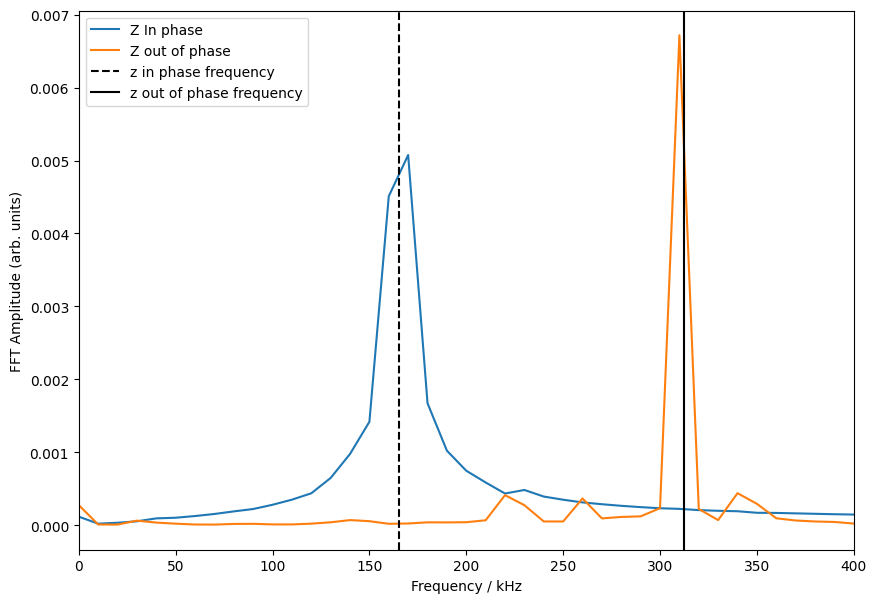

In [ ]:
ZInfft = fft(projZin)
ZOutfft = fft(projZout)
tfft = fftfreq(len(ts),np.diff(ts)[0])
fftfig,fftax = plt.subplots(figsize = (10,7))

fftax.plot(tfft[:len(ts)//2]*1e-3,np.abs(ZInfft)[0:len(ts)//2],label = 'Z In phase')
fftax.plot(tfft[:len(ts)//2]*1e-3,np.abs(ZOutfft)[0:len(ts)//2],label = 'Z out of phase')
fftax.set_xlim(0,400)
fftax.set_ylabel('FFT Amplitude (arb. units)')
fftax.set_xlabel('Frequency / kHz')
fftax.axvline(freqZin*1e-3/(2*np.pi),color = 'k',ls = '--',label = 'z in phase frequency')
fftax.axvline(freqZout*1e-3/(2*np.pi),color = 'k',label = 'z out of phase frequency')

fftax.legend()
plt.savefig('2IonFrequenciesZ.png')

Let us initialize the ions in the uncoolable state $z_{in}$, and then attempt to transfer the population.

In [ ]:
x1_init = 0
x2_init = 0


y1_init = 0
y2_init = 0

z1_init = zeq1+1e-4*z_in_mode[0]/np.sqrt(m1/amu)
z2_init = zeq2+1e-4*z_in_mode[1]/np.sqrt(m2/amu)

r1_init = np.array([x1_init,y1_init,z1_init])
r2_init = np.array([x2_init,y2_init,z2_init])

v1_init = np.zeros(3)
v2_init = np.zeros(3)
print('Initial displacements:')
print('z1: ',(z1_init-zeq1)*1e6,' um')
print('z2: ',(z2_init-zeq2)*1e6,' um')






current_pos1 = r1_init
current_vel1 = v1_init

current_pos2 = r2_init
current_vel2 = v2_init

t = 0
counter = 0
pos1s = []
pos2s = []
vel1s = []
vel2s = []
ts = []
current_state = 0

t_end = 1*1e-4

while t < t_end:
    next_t = t+dt                                                                                                                                   #Denote next time for later uses.
    Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)                                                                                           #Calculate coulomb force at time t
    current_force1 = TrapForce(Q1,current_pos1,V_DC+VTickle(VPrime,t,z_freqs[0],z_freqs[1]),V_RF,alpha,t) + Fcoul                                  #Calculate total force on ion 1
    current_force2 = TrapForce(Q2,current_pos2,V_DC+VTickle(VPrime,t,z_freqs[0],z_freqs[1]),V_RF,alpha,t) - Fcoul                                  #Calculate total force on ion 2


    next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2                         #Calculate next position of ion 1, as per velocity verlet
    next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2                         #Calculate next position of ion 2, as per velocity verlet

    next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)                                                   #Calculate Coulomb force, at next time step

    next_force1 = TrapForce(Q1,next_pos1,V_DC+VTickle(VPrime,next_t,z_freqs[0],z_freqs[1]),V_RF,alpha,next_t) + next_fcoul                              #Calculate forces on ion 1 and 2 at next timestep. Used for updating velocty
    next_force2 = TrapForce(Q2,next_pos2,V_DC+VTickle(VPrime,next_t,z_freqs[0],z_freqs[1]),V_RF,alpha,next_t) - next_fcoul

    next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt                                 # Update new velocities
    next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt

    if np.mod(counter,100) == 0:
        pos1s.append(current_pos1)                                                                         #Append positions and velocities, at every 500 time steps.
        pos2s.append(current_pos2)

        vel1s.append(current_vel1)
        vel2s.append(current_vel2)
        #print(Fcoul,current_force1-Fcoul)
        ts.append(t)
        counter = 0
    t+=dt                                                                                                  #Increment time and the counter for data storage. Update positions and velocities.
    counter +=1
    current_pos1 = next_pos1
    current_vel1 = next_vel1
    current_pos2 = next_pos2
    current_vel2 = next_vel2



Initial displacements:
z1:  4.169569746439294  um
z2:  5.532805038131401  um


Let's do a quick plot of the motion.

[array([0.00000000e+00, 0.00000000e+00, 9.60260388e-06]), array([0.00000000e+00, 0.00000000e+00, 9.59438338e-06]), array([0.00000000e+00, 0.00000000e+00, 9.56973113e-06]), array([0.00000000e+00, 0.00000000e+00, 9.52867575e-06]), array([0.00000000e+00, 0.00000000e+00, 9.47126792e-06]), array([0.0000000e+00, 0.0000000e+00, 9.3975847e-06]), array([0.00000000e+00, 0.00000000e+00, 9.30773517e-06]), array([0.00000000e+00, 0.00000000e+00, 9.20186715e-06]), array([0.00000000e+00, 0.00000000e+00, 9.08017457e-06]), array([0.00000000e+00, 0.00000000e+00, 8.94290516e-06]), array([0.000000e+00, 0.000000e+00, 8.790368e-06]), array([0.00000000e+00, 0.00000000e+00, 8.62294067e-06]), array([0.00000000e+00, 0.00000000e+00, 8.44107565e-06]), array([0.00000000e+00, 0.00000000e+00, 8.24530568e-06]), array([0.00000000e+00, 0.00000000e+00, 8.03624795e-06]), array([0.00000000e+00, 0.00000000e+00, 7.81460688e-06]), array([0.00000000e+00, 0.00000000e+00, 7.58117559e-06]), array([0.00000000e+00, 0.00000000e+00, 

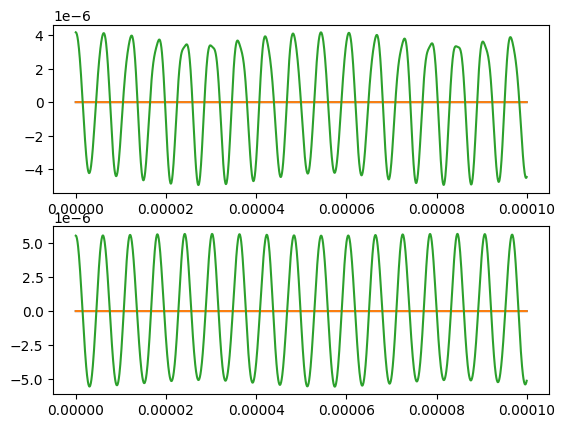

In [ ]:
print(pos1s)
fig,ax = plt.subplots(2,1)
ax[0].plot(ts,pos1s-np.array([0,0,zeq1]))
ax[1].plot(ts,pos2s-np.array([0,0,zeq2]))

Motion looks fine enough, that we believe we are still in the harmonic regime, i.e. the displacements do not become too high. Have we correctly put them into **only** $z_ {in}$?

Text(0.5, 0.98, 'Projections (arb. units)')

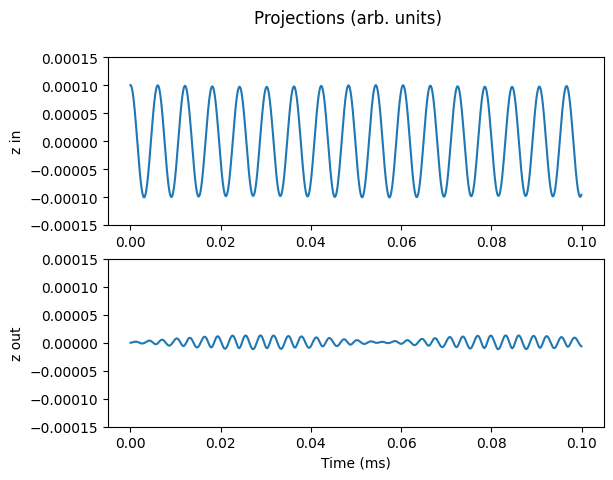

In [ ]:
zinProj = []
zoutProj = []

for z1,z2 in zip(np.array(pos1s)[:,2],np.array(pos2s)[:,2]):
    zinProj.append(displacementWProjection(z1,z2,zeq1,zeq2,m1,m2,z_in_mode))
    zoutProj.append(displacementWProjection(z1,z2,zeq1,zeq2,m1,m2,z_out_mode))
fig,ax = plt.subplots(2,1)

ax[0].plot(np.array(ts)*1e3,zinProj)
ax[1].plot(np.array(ts)*1e3,zoutProj)
labels = ['z in', 'z out']
for axe,label in zip(ax,labels):
    axe.set_ylim(-1.5*1e-4,1.5*1e-4)
    axe.set_ylabel(label)
ax[-1].set_xlabel('Time (ms)')
fig.suptitle('Projections (arb. units)')

Okay, we are quite clearly in the correct initialization! Let's try to shift!

In [ ]:
x1_init = 0
x2_init = 0


y1_init = 0
y2_init = 0

z1_init = zeq1+1e-4*z_in_mode[0]/np.sqrt(m1/amu)
z2_init = zeq2+1e-4*z_in_mode[1]/np.sqrt(m2/amu)

r1_init = np.array([x1_init,y1_init,z1_init])
r2_init = np.array([x2_init,y2_init,z2_init])

v1_init = np.zeros(3)
v2_init = np.zeros(3)
print('Initial displacements:')
print('z1: ',(z1_init-zeq1)*1e6,' um')
print('z2: ',(z2_init-zeq2)*1e6,' um')





VPrime = 0.05*V_DC
current_pos1 = r1_init
current_vel1 = v1_init

current_pos2 = r2_init
current_vel2 = v2_init

t = 0
counter = 0
pos1s = []
pos2s = []
vel1s = []
vel2s = []
ts = []
current_state = 0

t_end = 10*1e-3

while t < t_end:
    next_t = t+dt                                                                                                                                   #Denote next time for later uses.
    Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)                                                                                           #Calculate coulomb force at time t
    current_force1 = TrapForce(Q1,current_pos1,V_DC,V_RF,alpha,t) + Fcoul + TrapForce(Q1,current_pos1,VTickle(VPrime,t,freqZout,freqZin),0,0.5,t)                                 #Calculate total force on ion 1
    current_force2 = TrapForce(Q2,current_pos2,V_DC,V_RF,alpha,t) - Fcoul + TrapForce(Q2,current_pos2,VTickle(VPrime,t,freqZout,freqZin),0,0.5,t)                   #Calculate total force on ion 2


    next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2                         #Calculate next position of ion 1, as per velocity verlet
    next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2                         #Calculate next position of ion 2, as per velocity verlet

    next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)                                                   #Calculate Coulomb force, at next time step

    next_force1 = TrapForce(Q1,next_pos1,V_DC,V_RF,alpha,next_t) + next_fcoul + TrapForce(Q1,next_pos1,VTickle(VPrime,next_t,freqZout,freqZin),0,0.5,next_t)                              #Calculate forces on ion 1 and 2 at next timestep. Used for updating velocty
    next_force2 = TrapForce(Q2,next_pos2,V_DC,V_RF,alpha,next_t) - next_fcoul + TrapForce(Q2,next_pos2,VTickle(VPrime,next_t,freqZout,freqZin),0,0.5,next_t)

    next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt                                 # Update new velocities
    next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt

    if np.mod(counter,103) == 0:
        pos1s.append(current_pos1)                                                                         #Append positions and velocities, at every 500 time steps.
        pos2s.append(current_pos2)

        vel1s.append(current_vel1)
        vel2s.append(current_vel2)
        #print(Fcoul,current_force1-Fcoul)
        ts.append(t)
        counter = 0
    t+=dt                                                                                                  #Increment time and the counter for data storage. Update positions and velocities.
    counter +=1
    current_pos1 = next_pos1
    current_vel1 = next_vel1
    current_pos2 = next_pos2
    current_vel2 = next_vel2


Initial displacements:
z1:  4.169569746439294  um
z2:  5.532805038131401  um


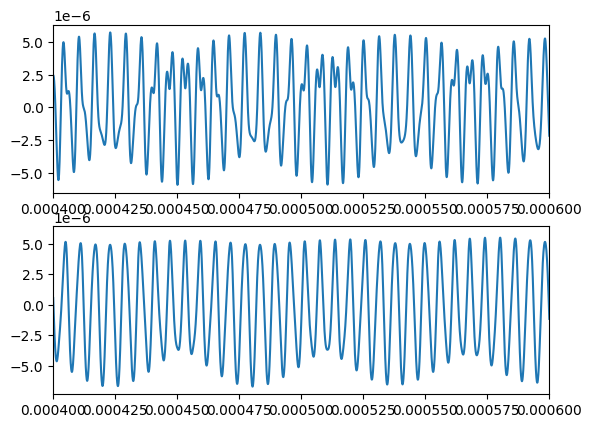

In [ ]:
np.savetxt('pos1Quartermix.txt',pos1s)
np.savetxt('pos2Quartermix.txt',pos2s)
np.savetxt('vel1Quartermix.txt',vel1s)
np.savetxt('vel2Quartermix.txt',vel2s)
np.savetxt('timeQuartermix.txt',ts)


fig,ax = plt.subplots(2,1)
ax[0].plot(ts,np.array(pos1s)[:,2]-zeq1)
ax[1].plot(ts,np.array(pos2s)[:,2]-zeq2)
for axe in ax:
    axe.set_xlim(0.0004,0.0006)

Text(0.5, 0, 'Time (ms)')

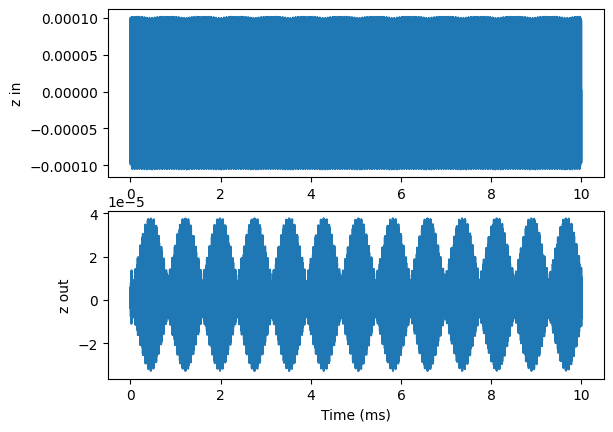

In [ ]:
zinProj = []
zoutProj = []

for z1,z2 in zip(np.array(pos1s)[:,2],np.array(pos2s)[:,2]):
    zinProj.append(displacementWProjection(z1,z2,zeq1,zeq2,m1,m2,z_in_mode))
    zoutProj.append(displacementWProjection(z1,z2,zeq1,zeq2,m1,m2,z_out_mode))
fig,ax = plt.subplots(2,1)

ax[0].plot(np.array(ts)*1e3,zinProj)
ax[1].plot(np.array(ts)*1e3,zoutProj)
labels = ['z in', 'z out']
for axe,label in zip(ax,labels):
    #axe.set_ylim(-2.2*1e-3,2.2*1e-3)
    axe.set_ylabel(label)
ax[-1].set_xlabel('Time (ms)')


That might be hard to track. Remember that the out of phase mode carries a lot less energy kinetic energy than the in phase mode (since masses are very different). Let's plot their kinetic energies.

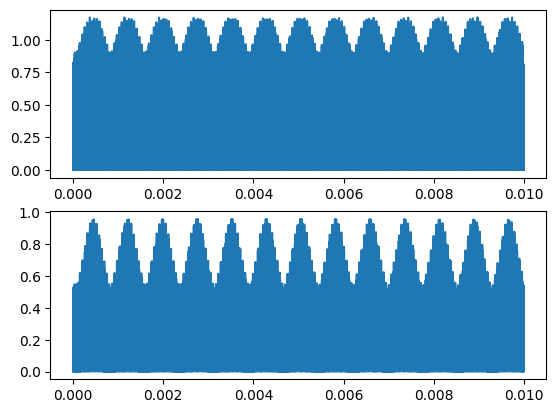

In [ ]:
TIn = []
TOut = []
for vel1,vel2 in zip(np.array(vel1s)[:,2],np.array(vel2s)[:,2]):
    TIn.append(z_in_mode[0]**2*m1*vel1**2+z_in_mode[1]**2*m2*vel2**2)
    TOut.append(z_out_mode[0]**2*m1*vel1**2+z_out_mode[1]**2*m2*vel2**2)

fig,ax = plt.subplots(2,1)
ax[0].plot(ts,np.array(TIn)/kb)
ax[1].plot(ts,np.array(TOut)/kb)

In [ ]:
# def minimizerTarget(d):
#     t = 0
#     counter = 0
#     pos1s = []
#     pos2s = []
#     vel1s = []
#     vel2s = []
#     ts = []

#     t_end = 10*1e-3
#     current_pos1 = r1_init
#     current_vel1 = v1_init

#     current_pos2 = r2_init
#     current_vel2 = v2_init
#     while t < t_end:
#         next_t = t+dt                                                                                                                                   #Denote next time for later uses.
#         Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)                                                                                           #Calculate coulomb force at time t
#         current_force1 = TrapForce(Q1,current_pos1,V_DC,V_RF,alpha,t) + Fcoul + TrapForce(Q1,current_pos1,VTickle(VPrime,t,freqZin+d,freqZout),0,0.5,t)                                 #Calculate total force on ion 1
#         current_force2 = TrapForce(Q2,current_pos2,V_DC,V_RF,alpha,t) - Fcoul + TrapForce(Q2,current_pos2,VTickle(VPrime,t,freqZin+d,freqZout),0,0.5,t)                   #Calculate total force on ion 2


#         next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2                         #Calculate next position of ion 1, as per velocity verlet
#         next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2                         #Calculate next position of ion 2, as per velocity verlet

#         next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)                                                   #Calculate Coulomb force, at next time step

#         next_force1 = TrapForce(Q1,next_pos1,V_DC,V_RF,alpha,next_t) + next_fcoul + TrapForce(Q1,next_pos1,VTickle(VPrime,next_t,freqZin+d,freqZout),0,0.5,next_t)                              #Calculate forces on ion 1 and 2 at next timestep. Used for updating velocty
#         next_force2 = TrapForce(Q2,next_pos2,V_DC,V_RF,alpha,next_t) - next_fcoul + TrapForce(Q2,next_pos2,VTickle(VPrime,next_t,freqZin+d,freqZout),0,0.5,next_t)

#         next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt                                 # Update new velocities
#         next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt

#         if np.mod(counter,103) == 0:
#             pos1s.append(current_pos1)                                                                         #Append positions and velocities, at every 500 time steps.
#             pos2s.append(current_pos2)

#             vel1s.append(current_vel1)
#             vel2s.append(current_vel2)
#             #print(Fcoul,current_force1-Fcoul)
#             ts.append(t)
#             counter = 0
#         t+=dt                                                                                                  #Increment time and the counter for data storage. Update positions and velocities.
#         counter +=1
#         current_pos1 = next_pos1
#         current_vel1 = next_vel1
#         current_pos2 = next_pos2
#         current_vel2 = next_vel2
#     zoutProj = []

#     for z1,z2 in zip(np.array(pos1s)[:,2],np.array(pos2s)[:,2]):
#         zoutProj.append(displacementWProjection(z1,z2,zeq1,zeq2,m1,m2,z_out_mode))
#     return np.min(-np.abs(zoutProj))

# #A = minimizerTarget()

In [ ]:
transferFiles = ['pos1Quartermix.txt','pos2Quartermix.txt','vel1Quartermix.txt','vel2Quartermix.txt','timeQuartermix.txt']


pos1 = np.loadtxt(transferFiles[0])
pos2 = np.loadtxt(transferFiles[1])
vel1 = np.loadtxt(transferFiles[2])
vel2 = np.loadtxt(transferFiles[3])
times = np.loadtxt(transferFiles[4])


#print(np.shape(pos1))
times = times[times <= 2*1e-3]
numPoints = len(times)
pos1 = pos1[0:numPoints,:]
pos2 = pos2[0:numPoints,:]
vel1 = vel1[0:numPoints,:]
vel2 = vel2[0:numPoints,:]


print(len(times))

30292


Energy transfer seems to have peaked at index:  18645


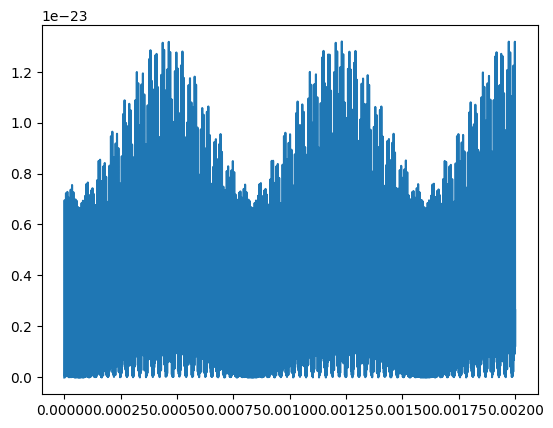

In [ ]:
fig, ax = plt.subplots()
TOut = []
for v1,v2 in zip(vel1,vel2):
    TOut.append(m1*z_out_mode[0]**2*v1[2]**2 + m2*z_out_mode[1]**2*v2[2]**2)
ax.plot(times,TOut)

maxIndex = np.argmax(TOut)
print('Energy transfer seems to have peaked at index: ',maxIndex)

Let's try to set the conditions of the system at the max energy transfer point as the initial conditions for applying cooling to the system! First we might need to take the nearest index where the Tickle goes to zero. But perhaps not. Let's try to just run a regular run, with no cooling to check.


In [ ]:
print(np.argmin(np.abs(np.cos((z_freqs[0]-z_freqs[1])*times[maxIndex-20:maxIndex+20]))))
print(np.cos((z_freqs[0]-z_freqs[1])*times[maxIndex-10]))


21
0.604164279017358


We want to make the swithcover smooth, i.e. do it when the tickle pulse has a node. This is 10 time points before maxIndex, according to above calculation.

In [ ]:
maxIndex -= 10

In [ ]:
VPrime = 0

r1_init = pos1[maxIndex]
r2_init = pos2[maxIndex]

v1_init = vel1[maxIndex]
v2_init = vel2[maxIndex]

t_init = times[maxIndex]

t = t_init
t_end = t_init +10*1e-3
pos1s = []
vel1s = []
pos2s = []
vel2s = []
ts = []
current_state = 0
current_pos1 = r1_init
current_pos2 = r2_init

current_vel1 = v1_init
current_vel2 = v2_init

counter = 0






while t < t_end:
    next_t = t+dt                                                                                                                                   #Denote next time for later uses.
    Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)                                                                                           #Calculate coulomb force at time t
    current_force1 = TrapForce(Q1,current_pos1,V_DC+VTickle(VPrime,t,z_freqs[0],z_freqs[1]),V_RF,alpha,t) + Fcoul                                  #Calculate total force on ion 1
    current_force2 = TrapForce(Q2,current_pos2,V_DC+VTickle(VPrime,t,z_freqs[0],z_freqs[1]),V_RF,alpha,t) - Fcoul                                  #Calculate total force on ion 2


    next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2                         #Calculate next position of ion 1, as per velocity verlet
    next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2                         #Calculate next position of ion 2, as per velocity verlet

    next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)                                                   #Calculate Coulomb force, at next time step

    next_force1 = TrapForce(Q1,next_pos1,V_DC+VTickle(VPrime,next_t,z_freqs[0],z_freqs[1]),V_RF,alpha,next_t) + next_fcoul                              #Calculate forces on ion 1 and 2 at next timestep. Used for updating velocty
    next_force2 = TrapForce(Q2,next_pos2,V_DC+VTickle(VPrime,next_t,z_freqs[0],z_freqs[1]),V_RF,alpha,next_t) - next_fcoul

    next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt                                 # Update new velocities
    next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt


    if current_state == 0:                                                                                 #This is the laser cooling logic tree. 0 = Ground state, 1 = Excited State.
        B12 = saturation*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel1))**2/(Gamma**2))                   #Calculate absorption rate
        rnd_nr = np.random.rand()
        if rnd_nr<B12*dt: #Absorb                                                                          #If TRUE: absorption happnes, velocity is updated and state changes
            next_vel1 +=hbar*k/m1
            current_state =1
    elif current_state ==1:                                                                                 
        B12 = saturation*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel1))**2/(Gamma**2))                   #If the ion was instead in the excited state, we once again check stim emission rate
        rnd_nr = np.random.rand()
        if rnd_nr < Gamma*dt:# spont emiss                                                                 #if TRUE spontaneous emission occurs, ion1 gets random kick
            next_vel1 += hbar/m1*k_norm*random_direction()
            current_state = 0
        elif rnd_nr < (Gamma+B12)*dt: #Stim emiss                                                          #else if TRUE stimulated emission occurs, ion1 gets a kick of -k
            next_vel1 -=hbar*k/m1
            current_state = 0

    if np.mod(counter,103) == 0:
        pos1s.append(current_pos1)                                                                         #Append positions and velocities, at every 500 time steps.
        pos2s.append(current_pos2)

        vel1s.append(current_vel1)
        vel2s.append(current_vel2)
        #print(Fcoul,current_force1-Fcoul)
        ts.append(t)
        counter = 0
    t+=dt                                                                                                  #Increment time and the counter for data storage. Update positions and velocities.
    counter +=1
    current_pos1 = next_pos1
    current_vel1 = next_vel1
    current_pos2 = next_pos2
    current_vel2 = next_vel2

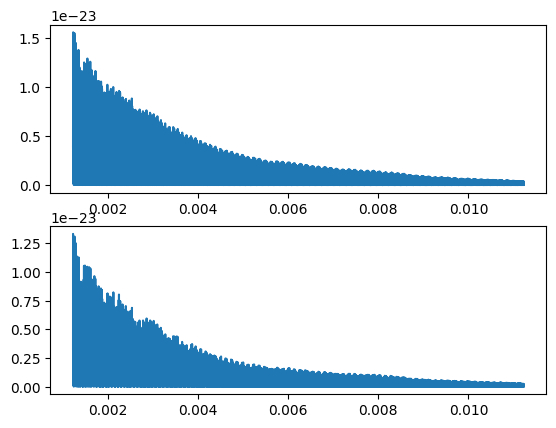

In [ ]:
fig,ax = plt.subplots(2,1)

TIn = []
TOut = []

for v1,v2 in zip(vel1s,vel2s):
    vz1 = v1[2]
    vz2 = v2[2]
    TIn.append(m1*z_in_mode[0]**2*vz1**2+m2*z_in_mode[1]**2*vz2**2)
    TOut.append(m1*z_out_mode[0]**2*vz1**2+m2*z_out_mode[1]**2*vz2**2)

ax[0].plot(ts,TIn)
ax[1].plot(ts,TOut)


In [ ]:
TInTransfer = []
TOutTransfer = []
for v1,v2 in zip(vel1[0:maxIndex],vel2[0:maxIndex]):
    TInTransfer.append(m1*z_in_mode[0]**2*v1[2]**2 + m2*z_in_mode[1]**2*v2[2]**2)
    TOutTransfer.append(m1*z_out_mode[0]**2*v1[2]**2 + m2*z_out_mode[1]**2*v2[2]**2)


TInTotal = np.concatenate((TInTransfer,TIn))
TOutTotal = np.concatenate((TOutTransfer,TOut))
timeTotal = np.concatenate((times[0:maxIndex],ts))

Text(0.5, 0, 'Time / ms')

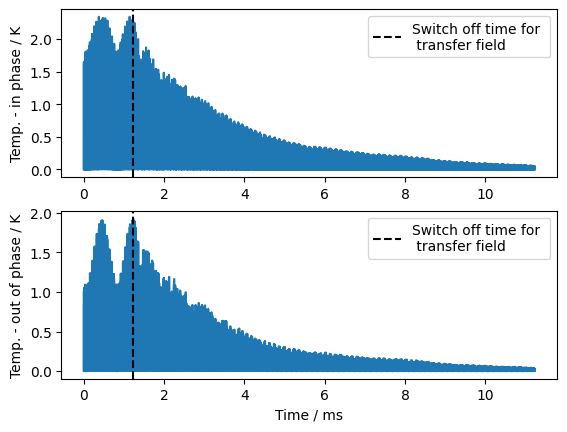

In [ ]:
fig,ax = plt.subplots(2,1)
ax[0].plot(timeTotal*1e3,TInTotal*2/kb)
ax[1].plot(timeTotal*1e3,TOutTotal*2/kb)
ax[0].set_ylabel('Temp. - in phase / K')
ax[1].set_ylabel('Temp. - out of phase / K')
ax[0].axvline(times[maxIndex]*1e3, color = 'k', ls = '--', label = 'Switch off time for \n transfer field')
ax[1].axvline(times[maxIndex]*1e3, color = 'k', ls = '--', label = 'Switch off time for \n transfer field')

ax[0].legend()
ax[1].legend()
ax[1].set_xlabel('Time / ms')

In [ ]:
np.savetxt('transferTimes.txt',timeTotal)
np.savetxt('transfer_KE_inz.txt',TInTotal)
np.savetxt('transfer_KE_outz.txt',TOutTotal)

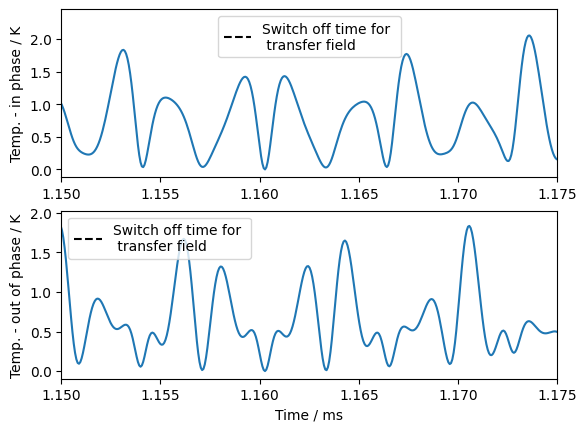

In [ ]:
ax[0].set_xlim(1.150,1.175)
ax[1].set_xlim(1.150,1.175)
fig

Clearly we do have a continuous boundary condition when going from one till the other.

In principle this seems functional. But maybe we should have some kind of envelope for the transfer field isntead? This could probably help with the seeming "sloshing towards the end". Nevertheless this simulation seems to be succseful. The energ moved by the transfer is brought away by the cooling beams. What does the temperature of the other modes look like? Just making sure we haven't messed those up accidentally. (Look just for the time we perform the transfer)

In [ ]:
TYIn = [y_in_mode[0]**2*m1*v1[1]**2+y_in_mode[1]**2*m2*v2[1]**2 for v1,v2 in zip(vel1,vel2)]
TYOut = [y_out_mode[0]**2*m1*v1[1]**2+y_out_mode[1]**2*m2*v2[1]**2 for v1,v2 in zip(vel1,vel2)]

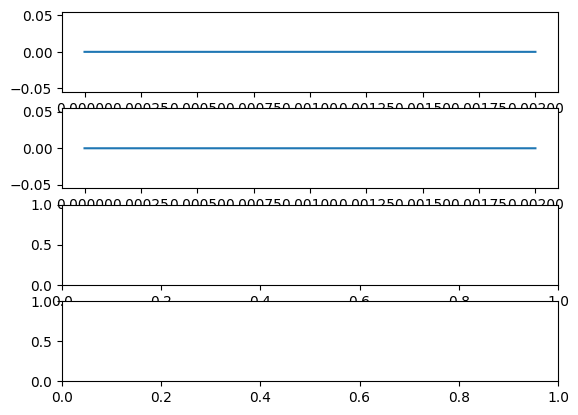

In [ ]:
fig, ax = plt.subplots(4,1)
ax[0].plot(times,TYIn)
ax[1].plot(times,TYOut)


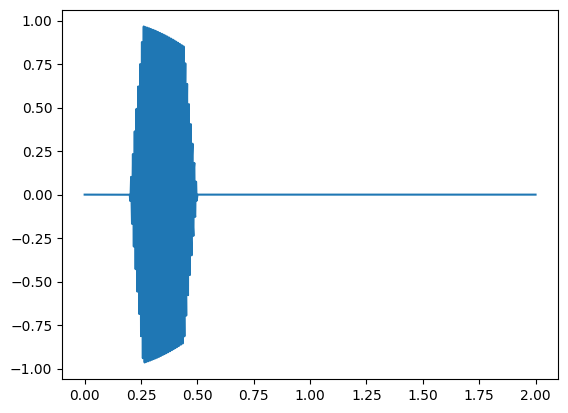

In [ ]:

    
test_end = 1
testV = 1
test_ts = np.linspace(0,2,1000)
omega1 = freqZin
omega2 = freqZout
testPulse = [shapedVTickle(0.2,0.3,testV,t,omega1,omega2) for t in test_ts]
fig,ax = plt.subplots()
ax.plot(test_ts,testPulse)


In [ ]:
pulseTime = times[maxIndex]
print(pulseTime)
print(testPulse)
test_ts = np.linspace(0,2*1e-3,1000)
testPulse = [shapedVTickle(pulseTime,testV,t,omega1,omega2) for t in test_ts]
fig, ax = plt.subplots()
ax.plot(test_ts,testPulse)

0.0012303878204745484
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.0005230587824972137, -0.03623038842446425, 0.011441189496977523, 0.10199224163626917, -0.023228735861399088, -0.1676027967049723, 0.03588421324510955, 0.2330534492522528, -0.04940606120287068, -0.29833560854048835, 0.06379264361092285, 0.36344069809599105, -0.07904224875196256, -0.42836015633564634, 0.09515308945225276, 0.49308543718171277, -0.11212330321177573, -0.5576080106975785, 0.12995095231819825, 0.6219193636993439, -0.1486340240349878, -0.6860110003826405, 0.16817043067011658, 0.749874442928035, -0.18855800975292758, -0.8135012321427773, 0.2097945242656818, 0.8768829280432846, -0.2318776625787897, -0.9400111105224865, 0.25370455202203107, 0.9664384268607006,

TypeError: shapedVTickle() missing 1 required positional argument: 'omega2'

In [ ]:
x1_init = 0
x2_init = 0


y1_init = 0
y2_init = 0

z1_init = zeq1+1e-4*z_in_mode[0]/np.sqrt(m1/amu)
z2_init = zeq2+1e-4*z_in_mode[1]/np.sqrt(m2/amu)

r1_init = np.array([x1_init,y1_init,z1_init])
r2_init = np.array([x2_init,y2_init,z2_init])

v1_init = np.zeros(3)
v2_init = np.zeros(3)
print('Initial displacements:')
print('z1: ',(z1_init-zeq1)*1e6,' um')
print('z2: ',(z2_init-zeq2)*1e6,' um')





VPrime = 0.05*V_DC
current_pos1 = r1_init
current_vel1 = v1_init

current_pos2 = r2_init
current_vel2 = v2_init

t = 0
counter = 0
pos1s = []
pos2s = []
vel1s = []
vel2s = []
ts = []
current_state = 0

t_end = 2*1e-3
pulseTime = 1.2*times[maxIndex]                                                                                                     # THis number has been found empirically by trial and error
while t < pulseTime:
    next_t = t+dt                                                                                                                                   #Denote next time for later uses.
    Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)                                                                                           #Calculate coulomb force at time t
    current_force1 = TrapForce(Q1,current_pos1,V_DC,V_RF,alpha,t) + Fcoul + TrapForce(Q1,current_pos1,shapedVTickle(0,pulseTime,VPrime,t,freqZout,freqZin),0,0.5,t)                                 #Calculate total force on ion 1
    current_force2 = TrapForce(Q2,current_pos2,V_DC,V_RF,alpha,t) - Fcoul + TrapForce(Q2,current_pos2,shapedVTickle(0,pulseTime,VPrime,t,freqZout,freqZin),0,0.5,t)                   #Calculate total force on ion 2


    next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2                         #Calculate next position of ion 1, as per velocity verlet
    next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2                         #Calculate next position of ion 2, as per velocity verlet

    next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)                                                   #Calculate Coulomb force, at next time step

    next_force1 = TrapForce(Q1,next_pos1,V_DC,V_RF,alpha,next_t) + next_fcoul + TrapForce(Q1,next_pos1,shapedVTickle(0,pulseTime,VPrime,next_t,freqZout,freqZin),0,0.5,next_t)                              #Calculate forces on ion 1 and 2 at next timestep. Used for updating velocty
    next_force2 = TrapForce(Q2,next_pos2,V_DC,V_RF,alpha,next_t) - next_fcoul + TrapForce(Q2,next_pos2,shapedVTickle(0,pulseTime,VPrime,next_t,freqZout,freqZin),0,0.5,next_t)

    next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt                                 # Update new velocities
    next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt

    if np.mod(counter,103) == 0:
        pos1s.append(current_pos1)                                                                         #Append positions and velocities, at every 500 time steps.
        pos2s.append(current_pos2)

        vel1s.append(current_vel1)
        vel2s.append(current_vel2)
        #print(Fcoul,current_force1-Fcoul)
        ts.append(t)
        counter = 0
    t+=dt                                                                                                  #Increment time and the counter for data storage. Update positions and velocities.
    counter +=1
    current_pos1 = next_pos1
    current_vel1 = next_vel1
    current_pos2 = next_pos2
    current_vel2 = next_vel2

Initial displacements:
z1:  0.7894383789097165  um
z2:  1.0496489493157592  um


In [ ]:
# vel1s = np.array(vel1s)
# vel2s = np.array(vel2s)
# print(np.shape(vel1s))

In [ ]:
# KZIn = [modeKineticEnergy(z_in_mode,np.sqrt(m1)*vz1,np.sqrt(m2)*vz2) for vz1,vz2 in zip(vel1s[:,2],vel2s[:,2])]
# KZOut = [modeKineticEnergy(z_out_mode,np.sqrt(m1)*vz1,np.sqrt(m2)*vz2) for vz1,vz2 in zip(vel1s[:,2],vel2s[:,2])]

In [ ]:
# fig,ax = plt.subplots(2,1)
# ts = np.array(ts)
# KZIn = np.array(KZIn)
# KZOut = np.array(KZOut)
# ax[0].plot(ts[ts< 2*1e-3]*1e3,KZIn[ts< 2*1e-3]/kb,label = 'In phase - axial')
# ax[1].plot(ts[ts< 2*1e-3]*1e3,KZOut[ts < 2*1e-3]/kb,label = 'Out of phase - axial')
# ax[1].set_xlabel('Time / ms')
# for axe in ax:
#     axe.set_ylabel(r'K.E. ($J/k_b$)')


Looks Good! Does cooling look nicer if we continue from this?


In [ ]:
VPrime = 0
r1_init = pos1s[-1]
r2_init = pos2s[-1]

v1_init = vel1s[-1]
v2_init = vel2s[-1]
t_init = ts[-1]

t = t_init
t_end = t_init +5*1e-3
# pos1s = []
# vel1s = []
# pos2s = []
# vel2s = []
# ts = []
current_state = 0
current_pos1 = r1_init
current_pos2 = r2_init

current_vel1 = v1_init
current_vel2 = v2_init

counter = 0






while t < t_end:
    next_t = t+dt                                                                                                                                   #Denote next time for later uses.
    Fcoul = CoulombForce(Q1,Q2,current_pos1,current_pos2)                                                                                           #Calculate coulomb force at time t
    current_force1 = TrapForce(Q1,current_pos1,V_DC+VTickle(VPrime,t,z_freqs[0],z_freqs[1]),V_RF,alpha,t) + Fcoul                                  #Calculate total force on ion 1
    current_force2 = TrapForce(Q2,current_pos2,V_DC+VTickle(VPrime,t,z_freqs[0],z_freqs[1]),V_RF,alpha,t) - Fcoul                                  #Calculate total force on ion 2


    next_pos1 = current_pos1 + current_vel1*dt + 1/(2*m1)*(current_force1) * dt**2                         #Calculate next position of ion 1, as per velocity verlet
    next_pos2 = current_pos2 + current_vel2*dt + 1/(2*m2)*(current_force2) * dt**2                         #Calculate next position of ion 2, as per velocity verlet

    next_fcoul = CoulombForce(Q1,Q2,next_pos1,next_pos2)                                                   #Calculate Coulomb force, at next time step

    next_force1 = TrapForce(Q1,next_pos1,V_DC+VTickle(VPrime,next_t,z_freqs[0],z_freqs[1]),V_RF,alpha,next_t) + next_fcoul                              #Calculate forces on ion 1 and 2 at next timestep. Used for updating velocty
    next_force2 = TrapForce(Q2,next_pos2,V_DC+VTickle(VPrime,next_t,z_freqs[0],z_freqs[1]),V_RF,alpha,next_t) - next_fcoul

    next_vel1 = current_vel1 + 1/(2*m1)*(current_force1 + next_force1) *dt                                 # Update new velocities
    next_vel2 = current_vel2 + 1/(2*m2)*(current_force2 + next_force2) *dt


    if current_state == 0:                                                                                 #This is the laser cooling logic tree. 0 = Ground state, 1 = Excited State.
        B12 = saturation*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel1))**2/(Gamma**2))                   #Calculate absorption rate
        rnd_nr = np.random.rand()
        if rnd_nr<B12*dt: #Absorb                                                                          #If TRUE: absorption happnes, velocity is updated and state changes
            next_vel1 +=hbar*k/m1
            current_state =1
    elif current_state ==1:                                                                                 
        B12 = saturation*Gamma*0.5/(1+4*(detuning-np.dot(k,current_vel1))**2/(Gamma**2))                   #If the ion was instead in the excited state, we once again check stim emission rate
        rnd_nr = np.random.rand()
        if rnd_nr < Gamma*dt:# spont emiss                                                                 #if TRUE spontaneous emission occurs, ion1 gets random kick
            next_vel1 += hbar/m1*k_norm*random_direction()
            current_state = 0
        elif rnd_nr < (Gamma+B12)*dt: #Stim emiss                                                          #else if TRUE stimulated emission occurs, ion1 gets a kick of -k
            next_vel1 -=hbar*k/m1
            current_state = 0

    if np.mod(counter,103) == 0:
        pos1s.append(current_pos1)                                                                         #Append positions and velocities, at every 500 time steps.
        pos2s.append(current_pos2)

        vel1s.append(current_vel1)
        vel2s.append(current_vel2)
        #print(Fcoul,current_force1-Fcoul)
        ts.append(t)
        counter = 0
    t+=dt                                                                                                  #Increment time and the counter for data storage. Update positions and velocities.
    counter +=1
    current_pos1 = next_pos1
    current_vel1 = next_vel1
    current_pos2 = next_pos2
    current_vel2 = next_vel2

In [ ]:
vel1s = np.array(vel1s)
vel2s = np.array(vel2s)

KZIn2 = [modeKineticEnergy(z_in_mode,np.sqrt(m1)*vz1,np.sqrt(m2)*vz2) for vz1,vz2 in zip(vel1s[:,2],vel2s[:,2])]
KZOut2 = [modeKineticEnergy(z_out_mode,np.sqrt(m1)*vz1,np.sqrt(m2)*vz2) for vz1,vz2 in zip(vel1s[:,2],vel2s[:,2])]

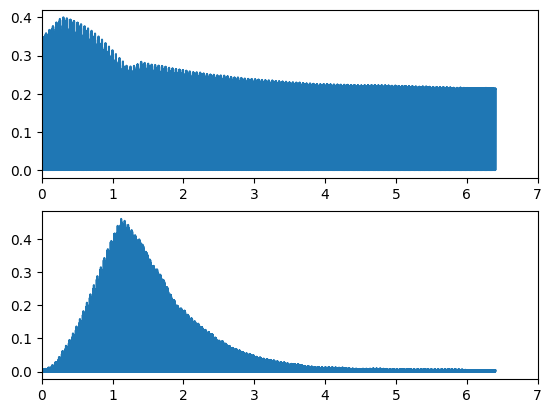

In [ ]:
fig,ax = plt.subplots(2,1)
ts = np.array(ts)
ax[0].plot(ts*1e3,np.array(KZIn2)/kb)
ax[1].plot(ts*1e3,np.array(KZOut2)/kb)
for axe in ax:
    axe.set_xlim(0,7)

With proof of concept let us see if we can write a function that does this in entirety:

In [ ]:
x1_init = 1e-5*x_in_mode[0]/np.sqrt(m1/amu)+1e-5*x_out_mode[0]/np.sqrt(m1/amu)
x2_init = 1e-5*x_in_mode[1]/np.sqrt(m2/amu)+1e-5*x_out_mode[1]/np.sqrt(m2/amu)


y1_init = 1e-5*y_in_mode[0]/np.sqrt(m1/amu)+1e-5*y_out_mode[0]/np.sqrt(m1/amu)
y2_init = 1e-5*y_in_mode[1]/np.sqrt(m2/amu)+1e-5*y_out_mode[1]/np.sqrt(m2/amu)

z1_init = zeq1+1e-5*z_in_mode[0]/np.sqrt(m1/amu)+1e-5*z_out_mode[0]/(np.sqrt(m1/amu))
z2_init = zeq2+1e-5*z_in_mode[1]/np.sqrt(m2/amu)+1e-5*z_out_mode[1]/(np.sqrt(m2/amu))

r1_init = np.array([x1_init,y1_init,z1_init])
r2_init = np.array([x2_init,y2_init,z2_init])

v1_init = np.zeros(3)
v2_init = np.zeros(3)


trap = TI.Trap(omega_RF,kappa,z0,r0)
tiSys = TI.two_ion_system(m1,Q1,m2,Q2,trap)
p1,p2,v1,v2,t = verletCool(r1_init,r2_init,v1_init,v2_init,0,5*1e-3,0,tiSys,[V_DC,V_RF],dt,103,0.1)

18.541631071307624 1287.825221642262


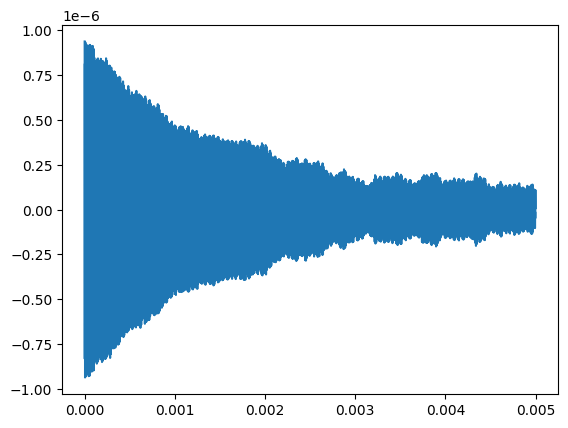

In [ ]:
fig,ax = plt.subplots()
ax.plot(t,np.array(p1)[:,2]-zeq1)

In [ ]:
x1_init = 0
x2_init = 0


y1_init = 0
y2_init = 0

z1_init = zeq1+1e-4*z_in_mode[0]/np.sqrt(m1/amu)
z2_init = zeq2+1e-4*z_in_mode[1]/np.sqrt(m2/amu)

r1_init = np.array([x1_init,y1_init,z1_init])
r2_init = np.array([x2_init,y2_init,z2_init])

v1_init = np.zeros(3)
v2_init = np.zeros(3)

# p1,p2,v1,v2,t = verletTransfer(r1_init,r2_init,v1_init,v2_init,freqZout,freqZin,0,2*1e-3,tiSys,[V_DC,V_RF,0.05*V_DC],dt,103,0.1)



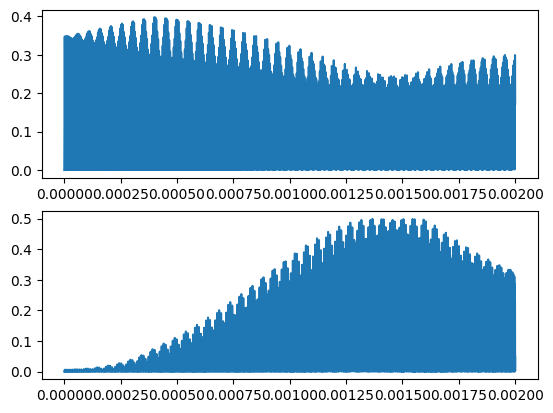

In [ ]:
KZIn = []
KZOut = []
for vz1,vz2 in zip(np.array(v1)[:,2],np.array(v2)[:,2]):
    KZIn.append(modeKineticEnergy(z_in_mode,np.sqrt(m1)*vz1,np.sqrt(m2)*vz2))
    KZOut.append(modeKineticEnergy(z_out_mode,np.sqrt(m1)*vz1,np.sqrt(m2)*vz2))

fig,ax = plt.subplots(2,1)
ax[0].plot(t,np.array(KZIn)/kb)
ax[1].plot(t,np.array(KZOut)/kb)

We now have a cooler and a transfer function. So let's just smack 'em together.

In [ ]:
no_runs = 10
##### setup initial conditions
coolerDuration = 5*1e-3
transferDuration = 1.5*1e-3
voltages =[V_DC,V_RF,0.05*V_DC]
t_init = 0
trap = TI.Trap(omega_RF,kappa,z0,r0)
tiSys = TI.two_ion_system(m1,Q1,m2,Q2,trap)
x1_init = 0
x2_init = 0


y1_init = 0
y2_init = 0

z1_init = zeq1+1e-4*z_in_mode[0]/np.sqrt(m1/amu)
z2_init = zeq2+1e-4*z_in_mode[1]/np.sqrt(m2/amu)

r1_init = np.array([x1_init,y1_init,z1_init])
r2_init = np.array([x2_init,y2_init,z2_init])

v1_init = np.zeros(3)
v2_init = np.zeros(3)

for j in range(no_runs):
    if j == 0:
        p1s,p2s,v1s,v2s,ts = verletTransfer(r1_init,r2_init,v1_init,v2_init,freqZout,freqZin,t_init,transferDuration,tiSys,voltages,dt,103,0.1)
        coolerp1s,coolerp2s,coolerv1s,coolerv2s,coolerTs = verletCool(p1s[-1],p2s[-1],v1s[-2],v2s[-1],ts[-1],coolerDuration,0,tiSys,voltages,dt,103,0.1)
        p1s += coolerp1s                                                                                        #NOTE THAT '+' FOR LISTS IS CONCATENATION
        p2s +=coolerp2s
        v1s += coolerv1s
        v2s += coolerv2s
        ts += coolerTs
    else:
        transferp1s,transferp2s,transferv1s,transferv2s,transferts = verletTransfer(p1s[-1],p2s[-1],v1s[-1],v2s[-1],freqZout,freqZin,ts[-1],transferDuration,tiSys,voltages,dt,103,0.1)
        p1s += transferp1s                                                                                        #NOTE THAT '+' FOR LISTS IS CONCATENATION
        p2s +=transferp2s
        v1s += transferv1s
        v2s += transferv2s
        ts += transferts
        coolerp1s,coolerp2s,coolerv1s,coolerv2s,coolerTs = verletCool(p1s[-1],p2s[-1],v1s[-2],v2s[-1],ts[-1],coolerDuration,0,tiSys,voltages,dt,103,0.1)
        p1s += coolerp1s                                                                                        #NOTE THAT '+' FOR LISTS IS CONCATENATION
        p2s +=coolerp2s
        v1s += coolerv1s
        v2s += coolerv2s
        ts += coolerTs

In [ ]:
KZIn = []
KZOut = []
KXIn = []
KYIn = []
KXOut = []
KYOut =  []
for v1,v2 in zip(np.array(v1s),np.array(v2s)):
    KZIn.append(modeKineticEnergy(z_in_mode,np.sqrt(m1)*v1[2],np.sqrt(m2)*v2[2]))
    KZOut.append(modeKineticEnergy(z_out_mode,np.sqrt(m1)*v1[2],np.sqrt(m2)*v2[2]))
    KYIn.append(modeKineticEnergy(y_in_mode,np.sqrt(m1)*v1[1],np.sqrt(m2)*v2[1]))
    KYOut.append(modeKineticEnergy(y_out_mode,np.sqrt(m1)*v1[1],np.sqrt(m2)*v2[1]))
    KXIn.append(modeKineticEnergy(x_in_mode,np.sqrt(m1)*v1[0],np.sqrt(m2)*v2[0]))
    KXOut.append(modeKineticEnergy(x_out_mode,np.sqrt(m1)*v1[0],np.sqrt(m2)*v2[0]))

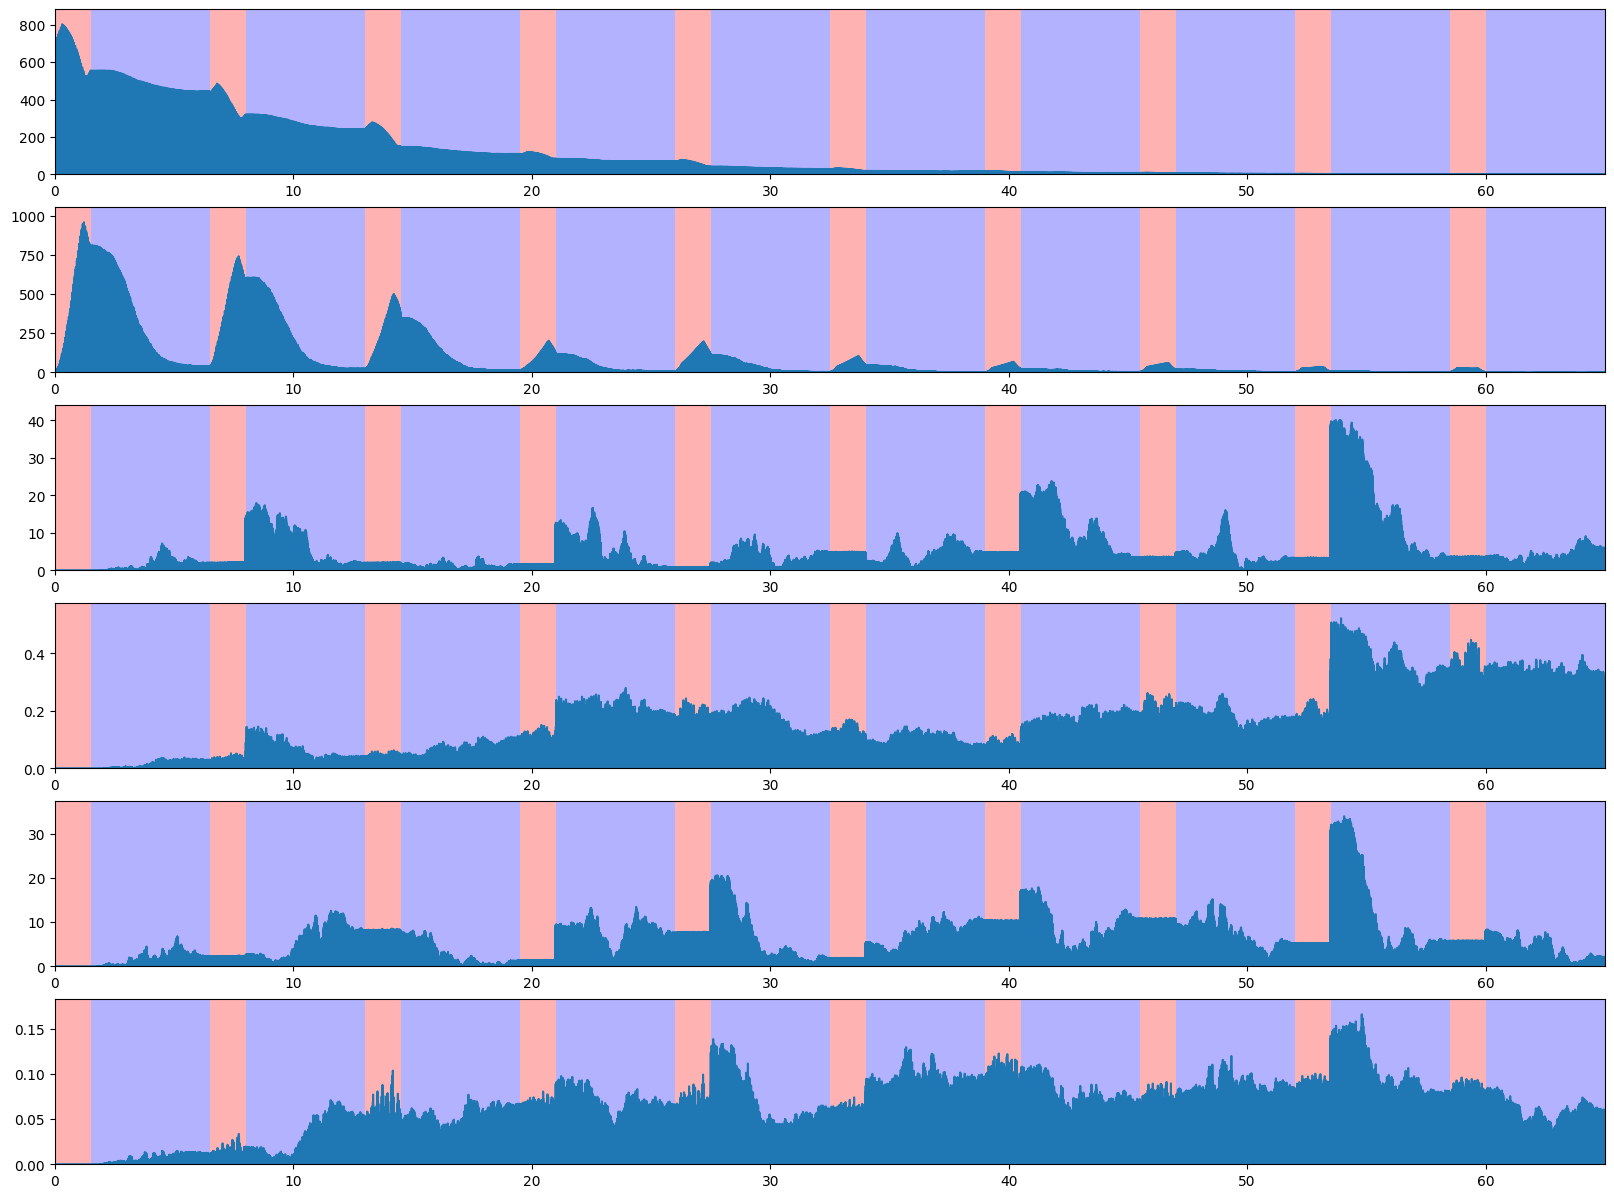

In [ ]:
fig,ax = plt.subplots(6,1,figsize = (20,15))
# np.savetxt('KZInPulses.txt',KZIn)
# np.savetxt('KZOutPulses.txt',KZOut)
# np.savetxt('timePulses.txt',ts)

for j,energy in enumerate([KZIn,KZOut,KYIn,KYOut,KXIn,KXOut]):
    ax[j].plot(np.array(ts)*1e3,np.array(energy)*2*1e3/kb)
    ax[j].set_xlim(ts[0]*1e3,ts[-1]*1e3)
    ax[j].set_ylim(0,2/kb*1.1*np.max(energy)*1e3)
    backgroundPainter(ax[j],no_runs,1.5,5)


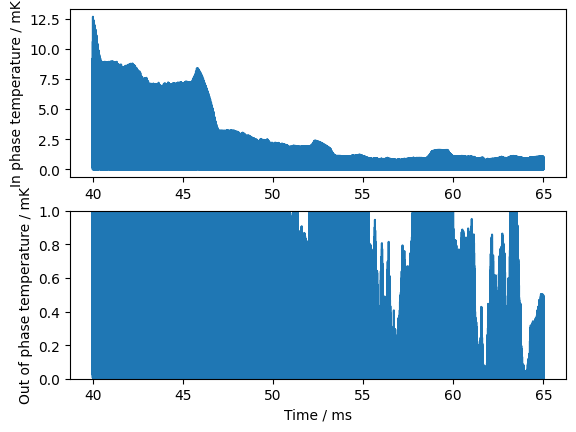

In [ ]:
fig,ax = plt.subplots(2,1)
ax[0].plot(1e3*np.array(ts)[np.array(ts)>0.04],2*np.array(KZIn)[np.array(ts)>0.04]/kb*1e3)
ax[1].plot(1e3*np.array(ts)[np.array(ts)>0.04],2*np.array(KZOut)[np.array(ts)>0.04]/kb*1e3)

ax[0].set_ylabel('In phase temperature / mK')
ax[1].set_ylabel('Out of phase temperature / mK')
ax[1].set_xlabel('Time / ms')
ax[1].set_ylim(0,1)


tCold = np.array(ts)[np.array(ts)>40*1e-3]
KZInCold = np.array(KZIn)[np.array(ts)>40*1e-3]
KZOutCold = np.array(KZOut)[np.array(ts)>40*1e-3]


tColdMean = meanCalculator(50,tCold)
KZInColdMean = meanCalculator(50,KZInCold)
KZOutColdMean = meanCalculator(50,KZOutCold)

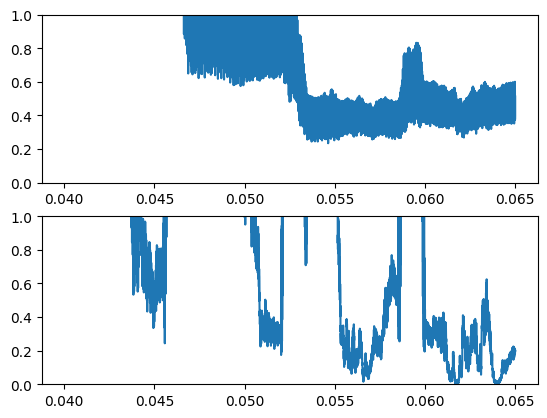

In [ ]:
fig,ax = plt.subplots(2,1)
ax[0].plot(tColdMean,2*KZInColdMean/kb*1e3)
ax[1].plot(tColdMean,2*KZOutColdMean/kb*1e3)

for axe in ax:
    axe.set_ylim(0,1)

Trying to write some code for a sin^2 pulse shape for the cooling laser.

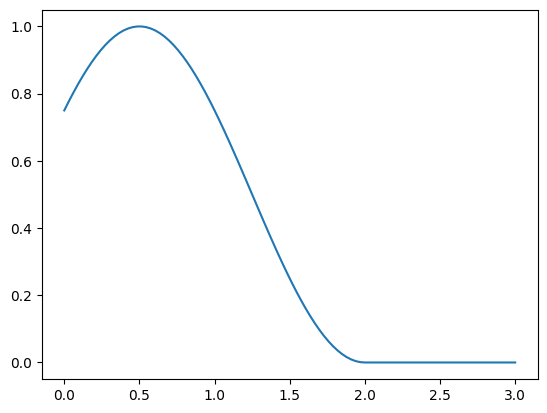

In [ ]:
t_test = np.linspace(0,3,100)
pulse = [shapedCooler(-1,2,t) for t in t_test]
fig,ax = plt.subplots()
ax.plot(t_test,pulse)

In [ ]:
voltages =[V_DC,V_RF,0.05*V_DC]
t_init = 0
trap = TI.Trap(omega_RF,kappa,z0,r0)
tiSys = TI.two_ion_system(m1,Q1,m2,Q2,trap)
x1_init = 0
x2_init = 0


y1_init = 0
y2_init = 0

z1_init = zeq1+1e-4*z_in_mode[0]/np.sqrt(m1/amu)
z2_init = zeq2+1e-4*z_in_mode[1]/np.sqrt(m2/amu)

r1_init = np.array([x1_init,y1_init,z1_init])
r2_init = np.array([x2_init,y2_init,z2_init])

v1_init = np.zeros(3)
v2_init = np.zeros(3)

p1Both,p2Both,v1Both,v2Both,tBoth = coolAndTransfer(r1_init,r2_init,v1_init,v2_init,freqZout,freqZin,0,20*1e-3,tiSys,voltages,dt,103,0.1,0.1,k)

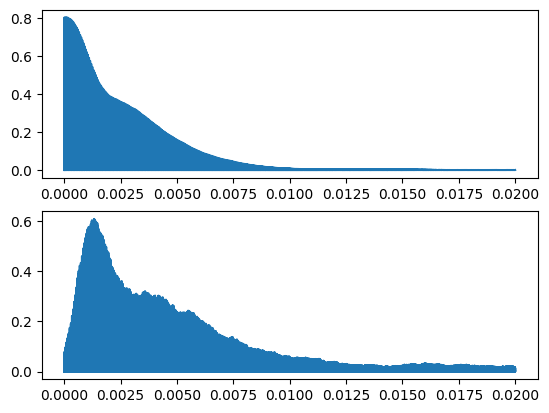

In [ ]:
fig,ax = plt.subplots(2,1)
ax[0].plot(tBoth,m2*np.array(v2Both)[:,2]**2/kb)
ax[1].plot(tBoth,m1*np.array(v1Both)[:,2]**2/kb)